# Phase 4 Project: Time Series
    This notebeok is where I'll be doing my work for the Phase 4 project. This project will be going through and predicting time series data; specifically real estated data provided by Zillow. So let's get started:
## Step 1: The business problem:
    A high-end development firm is looking to build office buildings in PA, for lease and/or sale. So they've tasked me with finding the best zip codes for such buildings, as well as predicting what potential returns they can expect.
## Step 2: Import libraries and data:

In [163]:
import pandas as pd
import pandas.tseries
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sb
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
import datetime as dt

Now we read the data. For simplicity I'm just using the data provided for the project instead of finding more recent data.

In [164]:
df=pd.read_csv('zillow_data.csv')

In [165]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

The SizeRank column seems to be related to population, not area.....I looked it up. That would've been really helpful.

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


Since we need to trim down this data, predicting values nationwide is a bit too much, I've decided I'm going to focus on my home state of Pennsylvania.

In [167]:
df1_pa=df.loc[df['State']=='PA']

In [168]:
df1_pa.head()

RegionID  RegionName          City State         Metro    CountyName  \
118     65133       17603     Lancaster    PA     Lancaster     Lancaster   
125     64180       15601    Greensburg    PA    Pittsburgh  Westmoreland   
194     65779       19111  Philadelphia    PA  Philadelphia  Philadelphia   
282     65791       19124  Philadelphia    PA  Philadelphia  Philadelphia   
329     65933       19446      Lansdale    PA  Philadelphia    Montgomery   

     SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
118       119   87700.0   89200.0   90600.0  ...   148400   149100   149800   
125       126   36100.0   36000.0   36100.0  ...   141200   142600   143900   
194       195   84600.0   84500.0   84400.0  ...   167100   168100   169300   
282       283   43100.0   43000.0   42900.0  ...    79800    80900    82200   
329       330  155300.0  154900.0  154600.0  ...   305400   307700   309200   

     2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
118   150400   151300   152300   153000   154300   156000   157000  
125   144400   144700   144700   144700   145100   145700   146100  
194   170600   171900   172700   173200   174000   175200   175800  
282    83000    83800    84300    84200    84900    86700    88200  
329   309300   308800   308900   310100   311600   314000   315900  

[5 rows x 272 columns]

In [169]:
def get_datetimes(df):
    return pd.to_datetime(df1_pa.columns.values[7:272], format='%Y-%m')

In [170]:
get_datetimes(df1_pa)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [171]:
df1_pa.head()

RegionID  RegionName          City State         Metro    CountyName  \
118     65133       17603     Lancaster    PA     Lancaster     Lancaster   
125     64180       15601    Greensburg    PA    Pittsburgh  Westmoreland   
194     65779       19111  Philadelphia    PA  Philadelphia  Philadelphia   
282     65791       19124  Philadelphia    PA  Philadelphia  Philadelphia   
329     65933       19446      Lansdale    PA  Philadelphia    Montgomery   

     SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
118       119   87700.0   89200.0   90600.0  ...   148400   149100   149800   
125       126   36100.0   36000.0   36100.0  ...   141200   142600   143900   
194       195   84600.0   84500.0   84400.0  ...   167100   168100   169300   
282       283   43100.0   43000.0   42900.0  ...    79800    80900    82200   
329       330  155300.0  154900.0  154600.0  ...   305400   307700   309200   

     2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
118   150400   151300   152300   153000   154300   156000   157000  
125   144400   144700   144700   144700   145100   145700   146100  
194   170600   171900   172700   173200   174000   175200   175800  
282    83000    83800    84300    84200    84900    86700    88200  
329   309300   308800   308900   310100   311600   314000   315900  

[5 rows x 272 columns]

In [172]:
df1_pa.loc[df['CountyName']=='Greene']

Empty DataFrame
Columns: [RegionID, RegionName, City, State, Metro, CountyName, SizeRank, 1996-04, 1996-05, 1996-06, 1996-07, 1996-08, 1996-09, 1996-10, 1996-11, 1996-12, 1997-01, 1997-02, 1997-03, 1997-04, 1997-05, 1997-06, 1997-07, 1997-08, 1997-09, 1997-10, 1997-11, 1997-12, 1998-01, 1998-02, 1998-03, 1998-04, 1998-05, 1998-06, 1998-07, 1998-08, 1998-09, 1998-10, 1998-11, 1998-12, 1999-01, 1999-02, 1999-03, 1999-04, 1999-05, 1999-06, 1999-07, 1999-08, 1999-09, 1999-10, 1999-11, 1999-12, 2000-01, 2000-02, 2000-03, 2000-04, 2000-05, 2000-06, 2000-07, 2000-08, 2000-09, 2000-10, 2000-11, 2000-12, 2001-01, 2001-02, 2001-03, 2001-04, 2001-05, 2001-06, 2001-07, 2001-08, 2001-09, 2001-10, 2001-11, 2001-12, 2002-01, 2002-02, 2002-03, 2002-04, 2002-05, 2002-06, 2002-07, 2002-08, 2002-09, 2002-10, 2002-11, 2002-12, 2003-01, 2003-02, 2003-03, 2003-04, 2003-05, 2003-06, 2003-07, 2003-08, 2003-09, 2003-10, 2003-11, 2003-12, ...]
Index: []

[0 rows x 272 columns]

I just wanted to see if my county made the list......it didn't. 

The next step will be in melting the data: turning the horizontally oriented dataframe, into a vertical one. This function came from the started notebook provided to us for the project.

# Melting the data

In [173]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [174]:
df1_pa.loc[df1_pa.index==11508]

RegionID  RegionName          City State         Metro  CountyName  \
11508     65715       19035  Lower Merion    PA  Philadelphia  Montgomery   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
11508     11509  490700.0  490300.0  489700.0  ...   957000   958700   957800   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
11508   955700   956700   959600   964600   969200   969600   968200  

[1 rows x 272 columns]

So that's test zip code, let's play around with it.

In [175]:
df1_pa_19035=df.loc[df['RegionName']==19035]

In [176]:
df1_pa_19035

RegionID  RegionName          City State         Metro  CountyName  \
11508     65715       19035  Lower Merion    PA  Philadelphia  Montgomery   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
11508     11509  490700.0  490300.0  489700.0  ...   957000   958700   957800   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
11508   955700   956700   959600   964600   969200   969600   968200  

[1 rows x 272 columns]

Ok, so let's melt the data, and see what we can do.

In [177]:
df1_pa_19035m=melt_data(df1_pa_19035)

In [178]:
df1_pa_19035m

value
time                
1996-04-01  490700.0
1996-05-01  490300.0
1996-06-01  489700.0
1996-07-01  489000.0
1996-08-01  488200.0
...              ...
2017-12-01  959600.0
2018-01-01  964600.0
2018-02-01  969200.0
2018-03-01  969600.0
2018-04-01  968200.0

[265 rows x 1 columns]

So I want to make a copy of this, just in case I mess it up somewhere along the line.

In [179]:
df1_pa_19035m_1=df1_pa_19035m

In [180]:
df1_pa_19035m = df1_pa_19035m.asfreq('MS')
df1_pa_19035m_1=df1_pa_19035m_1.asfreq('MS')

In [181]:
df1_pa_19035m.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='time', length=265, freq='MS')

So let's look take a closer look at our test case. We're going to see how it changes month to month.

In [182]:
df1_pa_19035m_1['Difference'] = df1_pa_19035m['value'].diff()
df_diff = df1_pa_19035m_1['Difference']

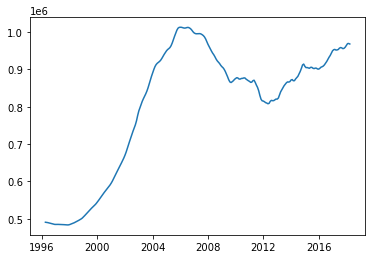

In [183]:
plt.plot(df1_pa_19035m['value'])

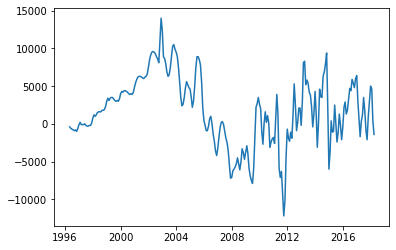

In [184]:
plt.plot(df1_pa_19035m_1['Difference'])

Now we can decompose the data, to give as sense of the trends. I'm not sure how much I'll need this, since I don't plan on using any manual madeling. The plan here will be to use models that automatically find the trends and adjust their hyperparameters.

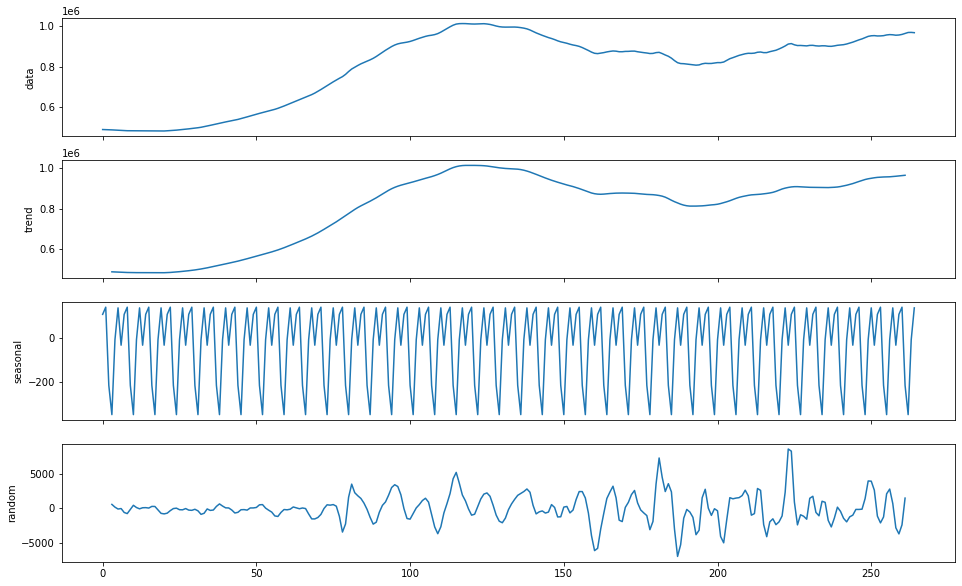

In [185]:
decomposed = decompose(df1_pa_19035m['value'].values, 'additive', m=7)
decomposed_plot(decomposed, figure_kwargs={'figsize': (16, 10)})
plt.show()

So I'm not 100% sure how to read all this, but I'm sure it's not stationary yet.

We'll need this function to evaluate our models.

In [186]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

Most important right now, is figuring out how we're going to pick the 5 zip codes to look at. And I think it'll be best to simply melt the entire dataframe, plot it, and then pick the ones that look the best.

In [187]:
df1_pa['RegionName'][118]

17603

In [188]:
df1_pa.index[0]

118

In [189]:
df1_pa['RegionName'][df1_pa.index[0]]

17603

In [190]:
dum1=df1_pa['RegionName'][df1_pa.index[0]]

Ok, let's put this into a loop. Step by step.

In [191]:
#Step 1, grab the first row in the dataframe
df1_pa_row1=df1_pa.loc[df1_pa['RegionName']== dum1]

In [192]:
df1_pa_row1

RegionID  RegionName       City State      Metro CountyName  SizeRank  \
118     65133       17603  Lancaster    PA  Lancaster  Lancaster       119   

     1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
118  87700.0  89200.0  90600.0  ...   148400   149100   149800   150400   

     2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
118   151300   152300   153000   154300   156000   157000  

[1 rows x 272 columns]

In [193]:
#Step 2, melt the dataframe
frst_row_m=melt_data(df1_pa_row1)

In [194]:
frst_row_m

value
time                
1996-04-01   87700.0
1996-05-01   89200.0
1996-06-01   90600.0
1996-07-01   92000.0
1996-08-01   93300.0
...              ...
2017-12-01  152300.0
2018-01-01  153000.0
2018-02-01  154300.0
2018-03-01  156000.0
2018-04-01  157000.0

[265 rows x 1 columns]

In [195]:
#Setp 3: rename 'value' to the RegionName
frst_row_m.rename(columns={"value": dum1},inplace=True)

In [196]:
#Step 4: Create an new dataframe
df_pa_time = frst_row_m

In [197]:
#Step 5: Combine the code into a for loop:
for each in df1_pa.index:
    dum2=df1_pa['RegionName'][each]
    new_row=df1_pa.loc[df1_pa['RegionName']== dum2]
    new_row_m=melt_data(new_row)
    new_row_m.rename(columns={"value": dum2},inplace=True)
    df_pa_time[dum2]=new_row_m

In [198]:
df_pa_time

17603     15601     19111    19124     19446     19020  \
time                                                                    
1996-04-01   87700.0   36100.0   84600.0  43100.0  155300.0  122000.0   
1996-05-01   89200.0   36000.0   84500.0  43000.0  154900.0  121800.0   
1996-06-01   90600.0   36100.0   84400.0  42900.0  154600.0  121600.0   
1996-07-01   92000.0   36100.0   84200.0  42700.0  154200.0  121300.0   
1996-08-01   93300.0   36200.0   84100.0  42500.0  153900.0  121000.0   
...              ...       ...       ...      ...       ...       ...   
2017-12-01  152300.0  144700.0  172700.0  84300.0  308900.0  256400.0   
2018-01-01  153000.0  144700.0  173200.0  84200.0  310100.0  257500.0   
2018-02-01  154300.0  145100.0  174000.0  84900.0  311600.0  257600.0   
2018-03-01  156000.0  145700.0  175200.0  86700.0  314000.0  255600.0   
2018-04-01  157000.0  146100.0  175800.0  88200.0  315900.0  253400.0   

              19120     15301     17331     19067  ...     16613     15340  \
time                                               ...                       
1996-04-01  46100.0   58000.0   90500.0  181300.0  ...       NaN   60600.0   
1996-05-01  46100.0   57900.0   90400.0  181000.0  ...       NaN   60800.0   
1996-06-01  46100.0   57900.0   90400.0  180700.0  ...       NaN   60900.0   
1996-07-01  46100.0   57900.0   90500.0  180500.0  ...       NaN   61000.0   
1996-08-01  46000.0   57900.0   90600.0  180300.0  ...       NaN   61200.0   
...             ...       ...       ...       ...  ...       ...       ...   
2017-12-01  88900.0  133900.0  167000.0  395900.0  ...  107300.0  145100.0   
2018-01-01  90100.0  134700.0  166900.0  397900.0  ...  108600.0  145800.0   
2018-02-01  91400.0  134900.0  167800.0  399200.0  ...  108300.0  146900.0   
2018-03-01  92200.0  133900.0  169300.0  400000.0  ...  106500.0  147600.0   
2018-04-01  92400.0  133200.0  169900.0  400600.0  ...  105600.0  147700.0   

              15849    16738    15673     18915     15015    16836    17006  \
time                                                                          
1996-04-01  17800.0  30300.0  50300.0  165300.0  174900.0  13500.0  37600.0   
1996-05-01  17900.0  30300.0  50400.0  165300.0  174200.0  13500.0  37800.0   
1996-06-01  18000.0  30300.0  50500.0  165400.0  173500.0  13500.0  38000.0   
1996-07-01  18100.0  30300.0  50500.0  165400.0  172800.0  13400.0  38200.0   
1996-08-01  18100.0  30400.0  50600.0  165400.0  172200.0  13400.0  38400.0   
...             ...      ...      ...       ...       ...      ...      ...   
2017-12-01  46700.0  70900.0  81900.0  322000.0  309500.0  55900.0  69300.0   
2018-01-01  46600.0  70000.0  81800.0  322700.0  310400.0  55400.0  69500.0   
2018-02-01  46000.0  70100.0  82000.0  323900.0  312800.0  55400.0  69400.0   
2018-03-01  45000.0  71100.0  83300.0  325700.0  318600.0  56800.0  70000.0   
2018-04-01  44500.0  71800.0  85000.0  327000.0  323300.0  58300.0  70800.0   

              15083  
time                 
1996-04-01  34700.0  
1996-05-01  34500.0  
1996-06-01  34400.0  
1996-07-01  34300.0  
1996-08-01  34200.0  
...             ...  
2017-12-01  77200.0  
2018-01-01  76900.0  
2018-02-01  77700.0  
2018-03-01  80500.0  
2018-04-01  82600.0  

[265 rows x 831 columns]

Perfect. Now to save some time later, we'll set the frequency to 'month-start' as well as make a copy that is daily, this will be necessary (easier?) for when we use Prophet later on.

In [199]:
df_pa_time=df_pa_time.asfreq('MS')
df_pa_time_d=df_pa_time.asfreq('d',method='ffill')

I'm also going to create an empty, 'future' dataframe. I think I can store the predictions here for plotting later. It's an idea I just had.

In [200]:
index = pd.date_range('2018-05-01', periods=60, freq='MS')
 
columns = ['z19103', 'z19106', 'z19041','z19085','z19035']
 
df_future = pd.DataFrame(index=index, columns=columns)

Ok, so let's make kplots of over 800 rows. Then look them over and decide which ones are worth investing in.

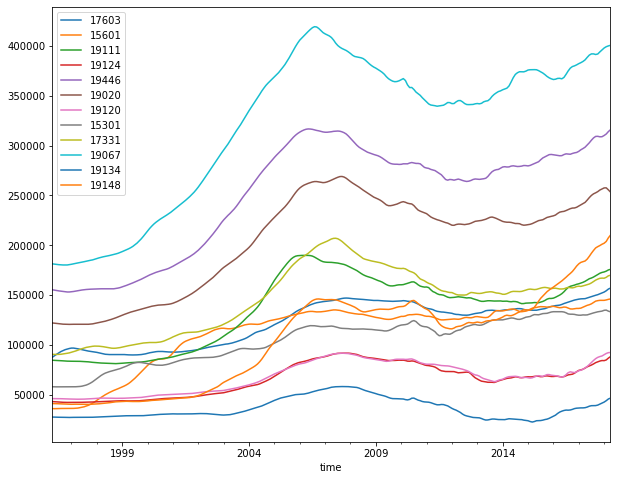

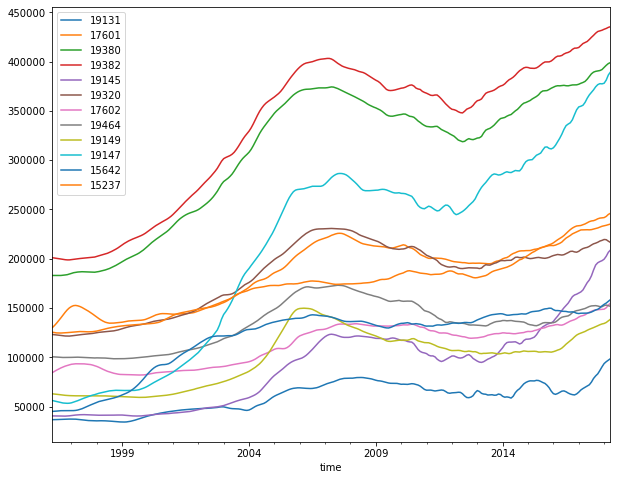

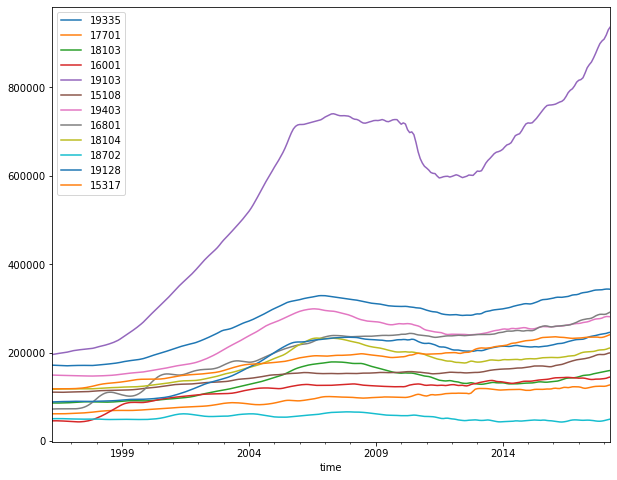

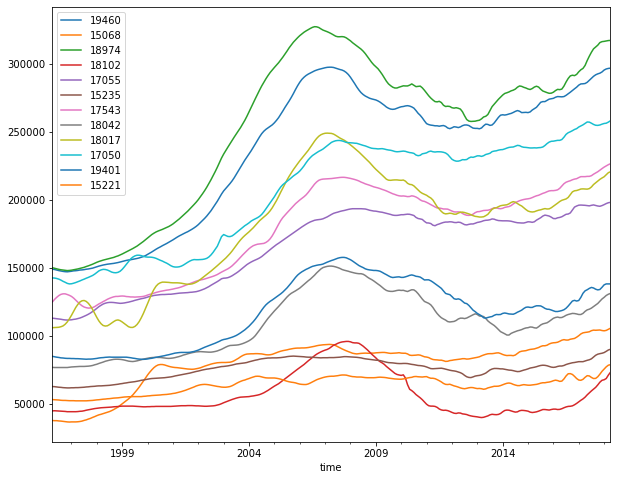

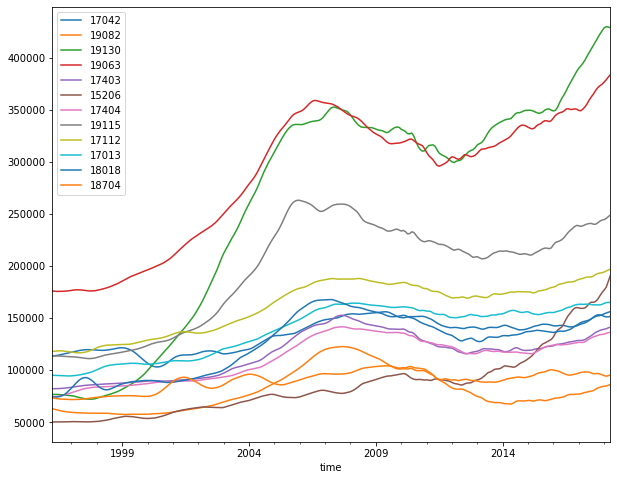

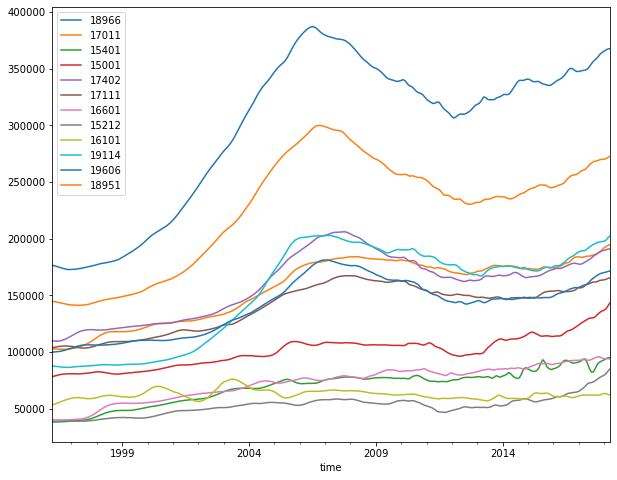

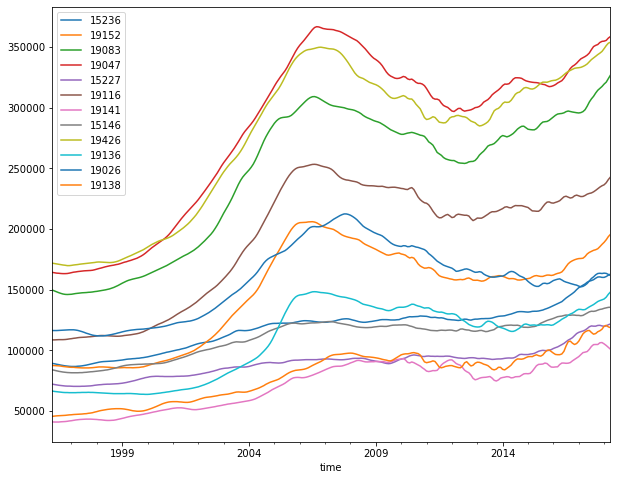

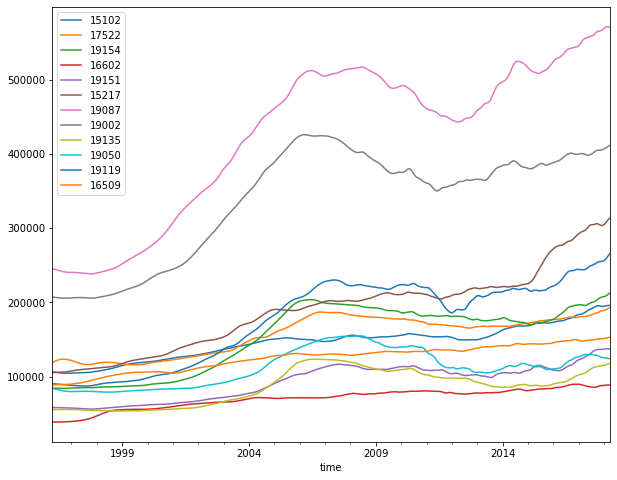

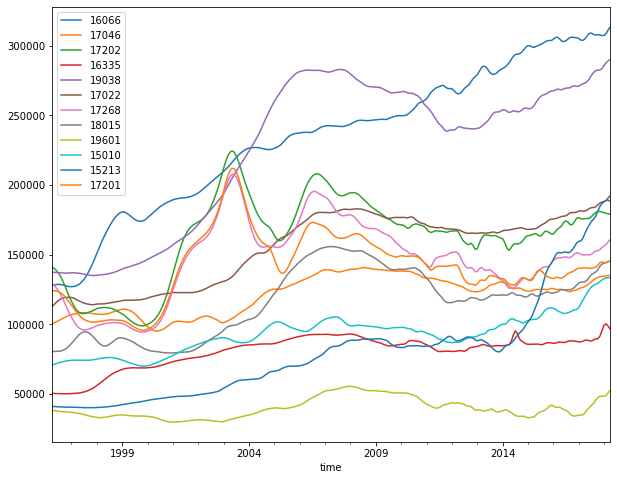

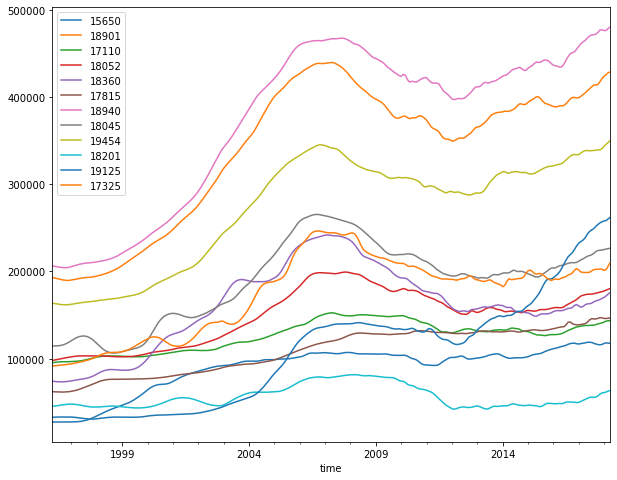

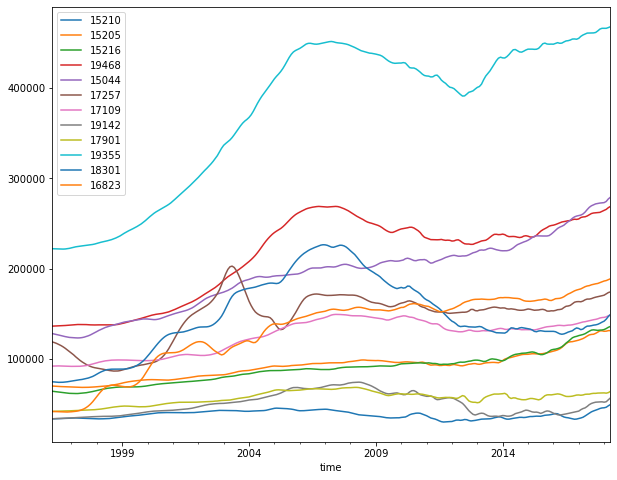

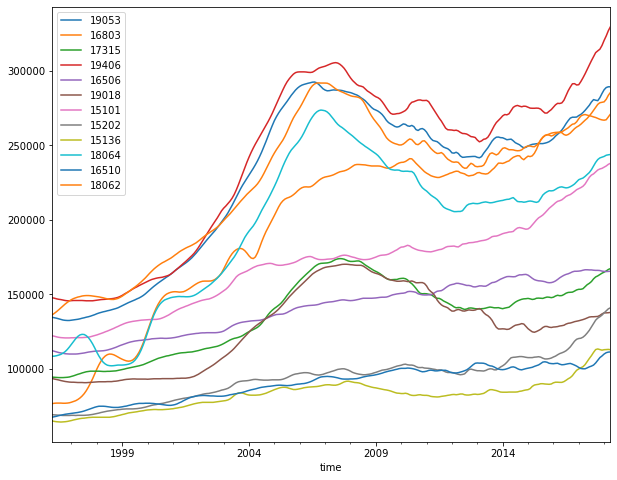

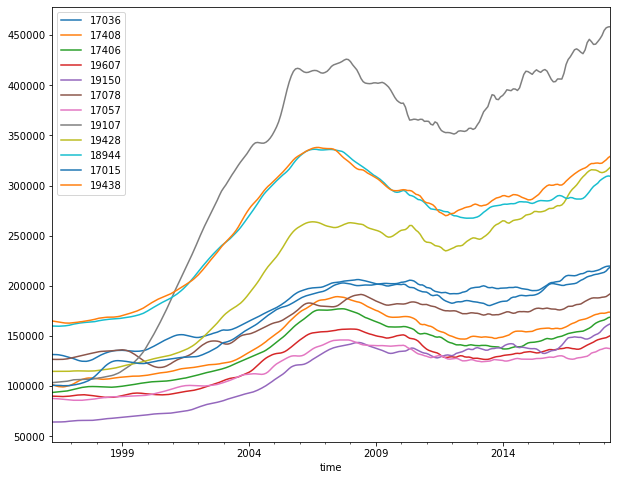

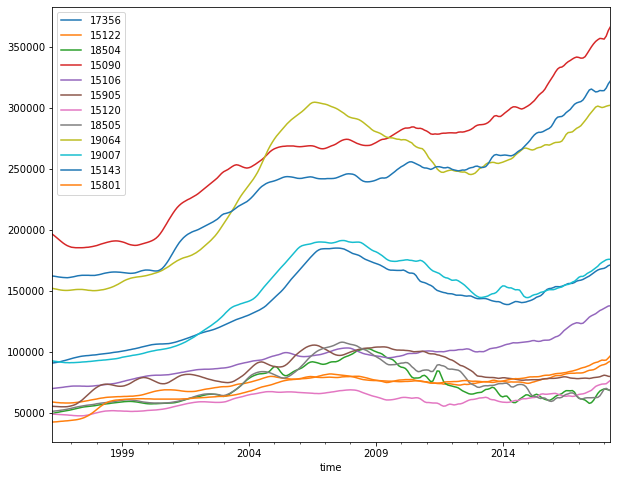

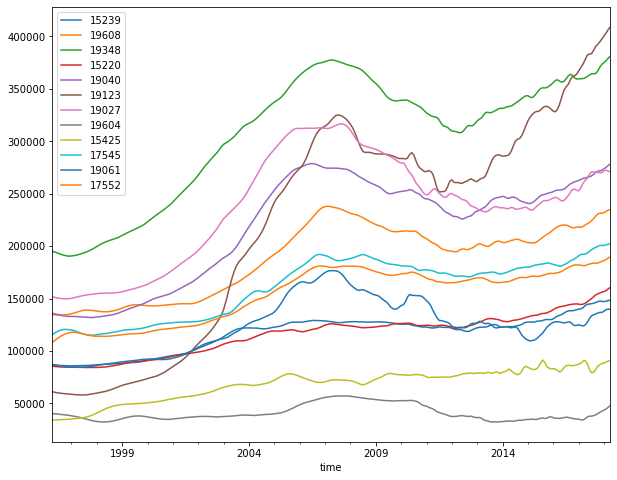

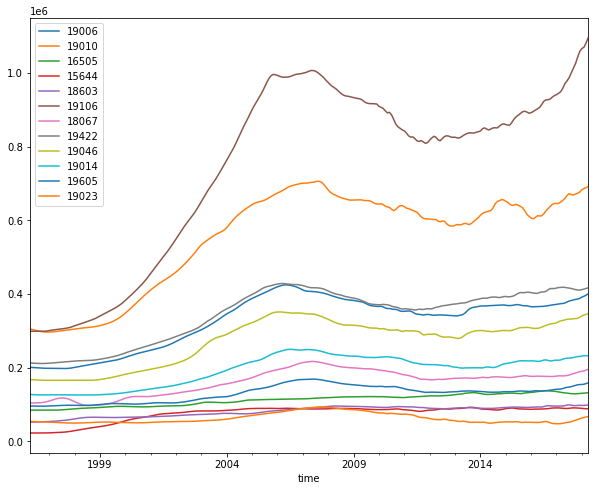

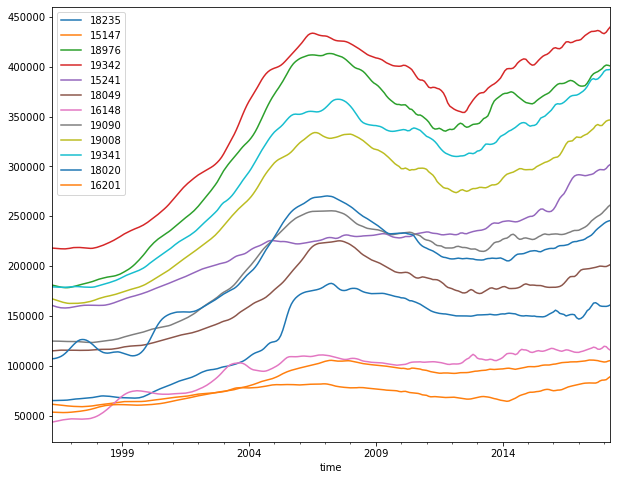

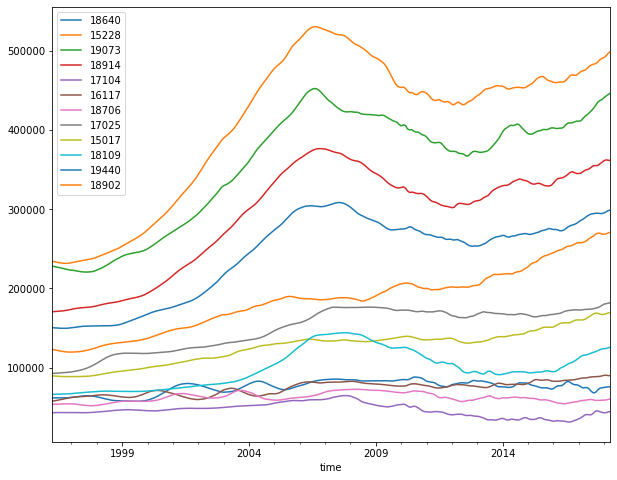

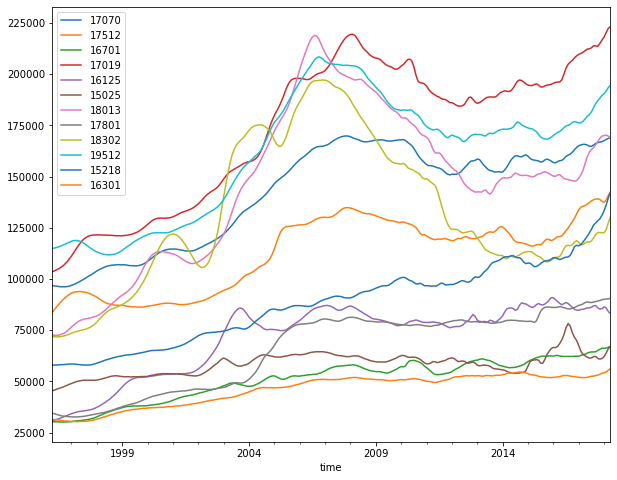

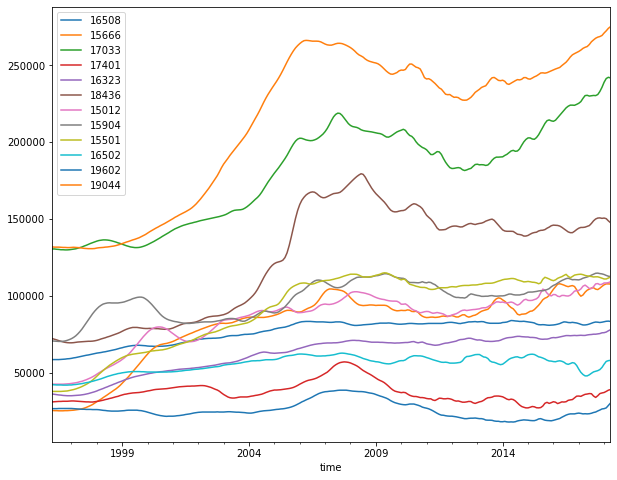

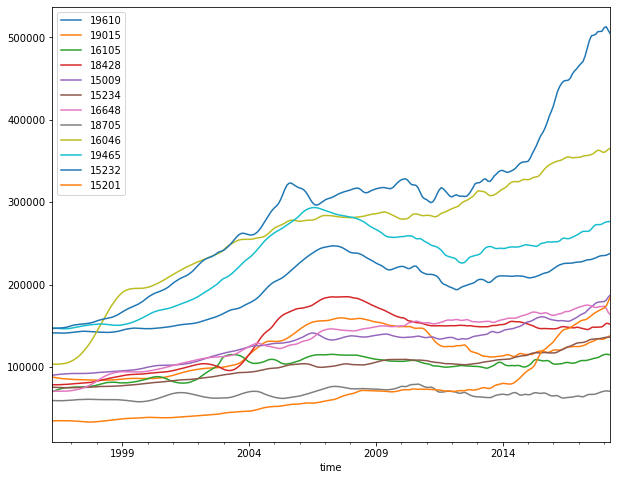

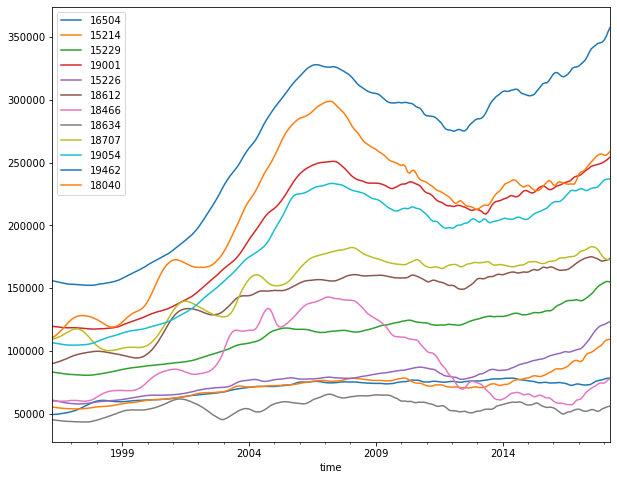

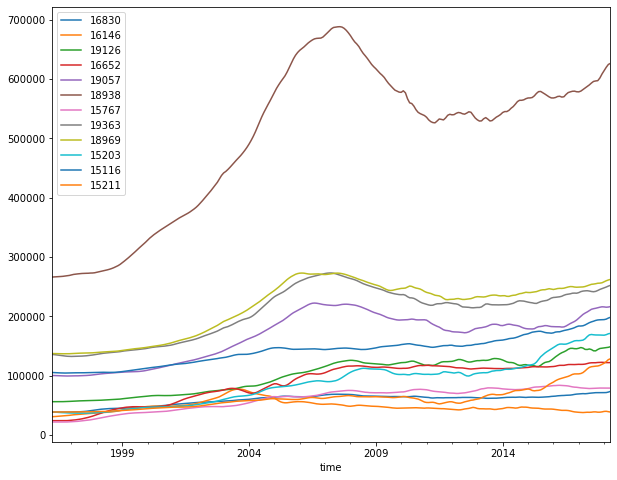

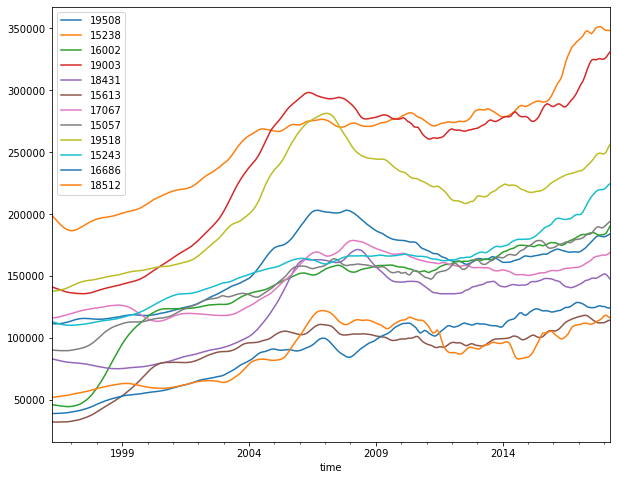

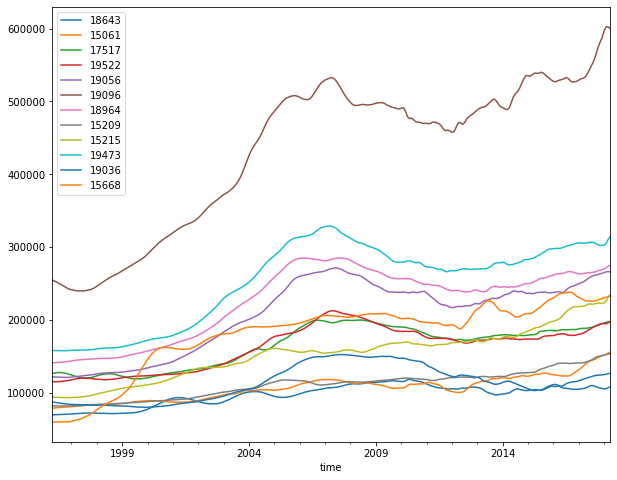

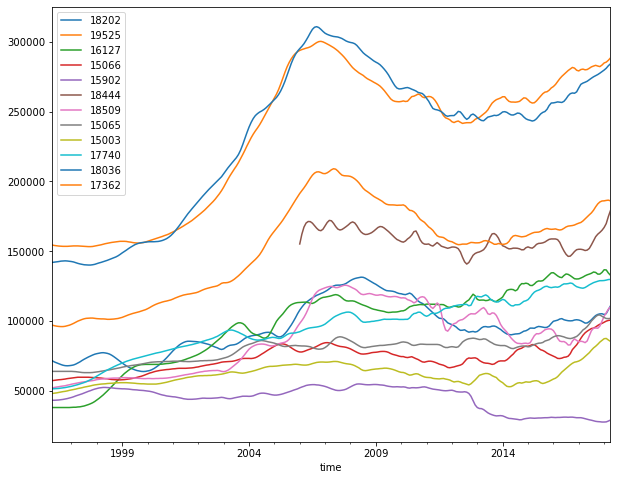

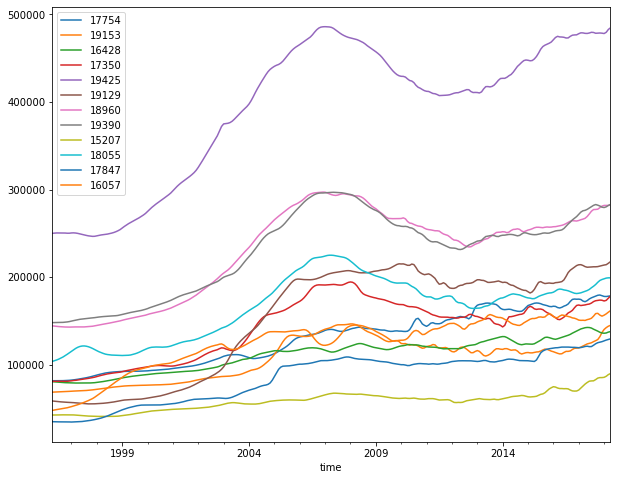

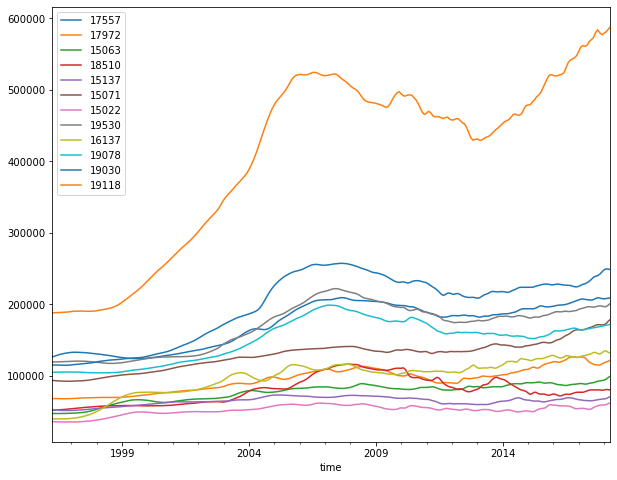

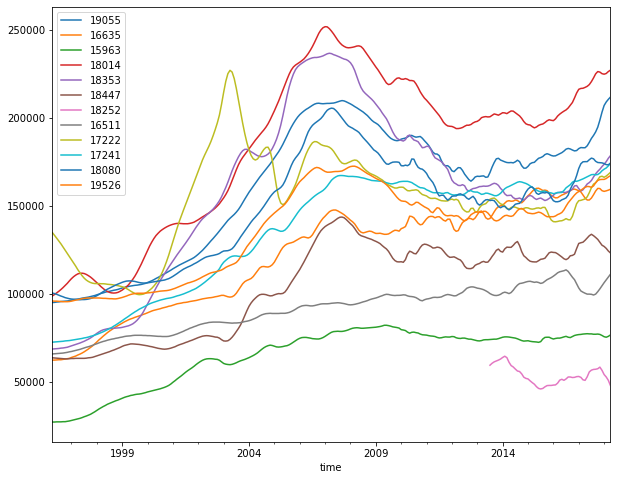

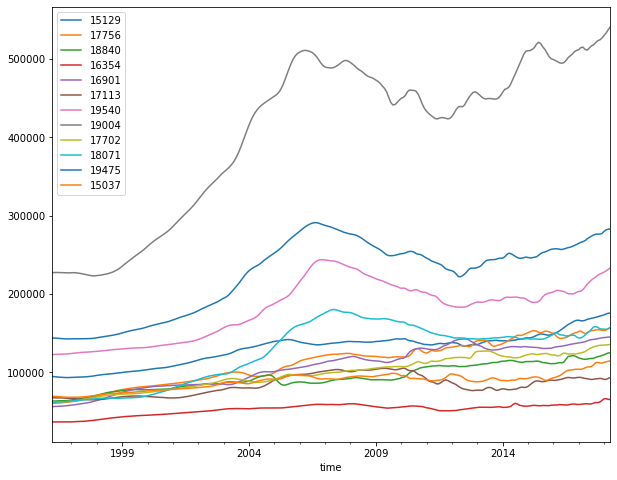

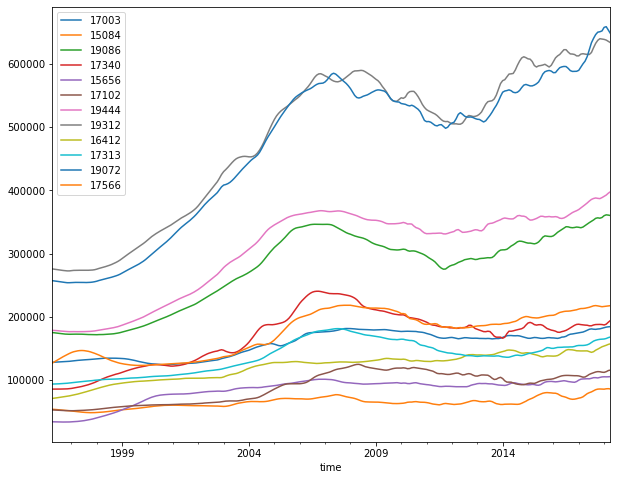

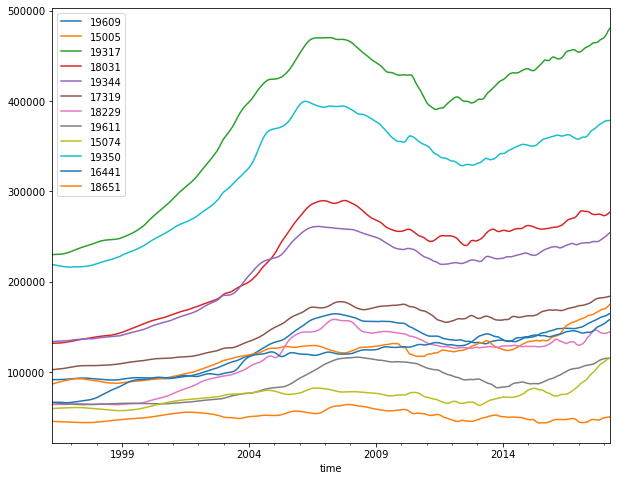

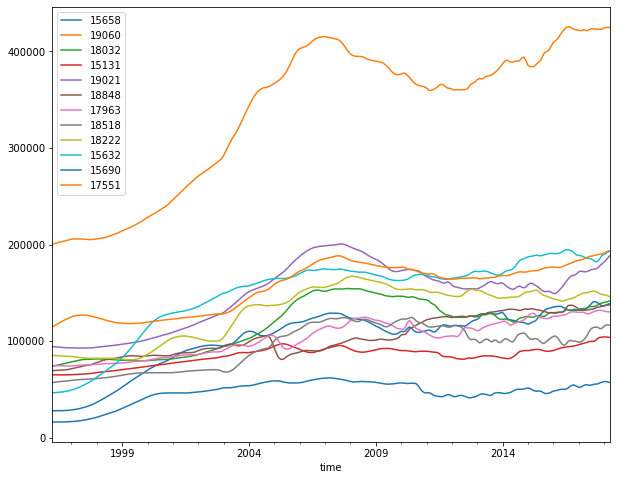

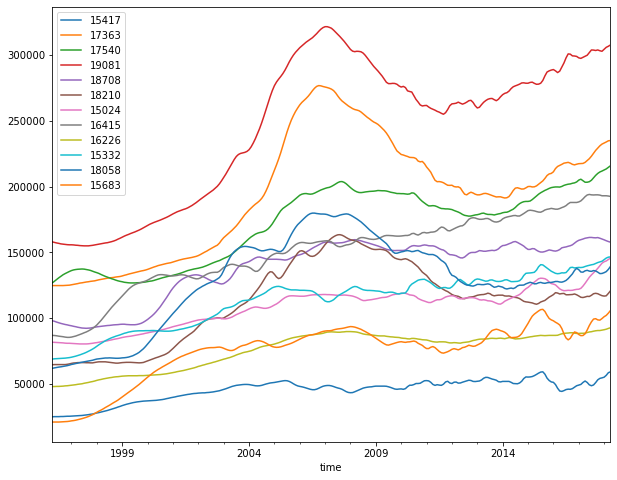

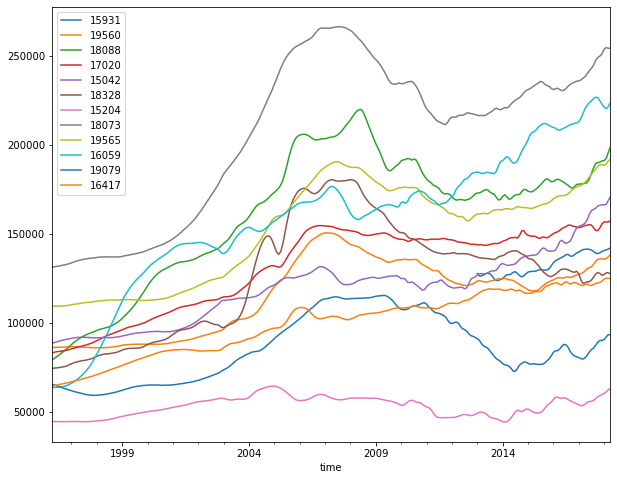

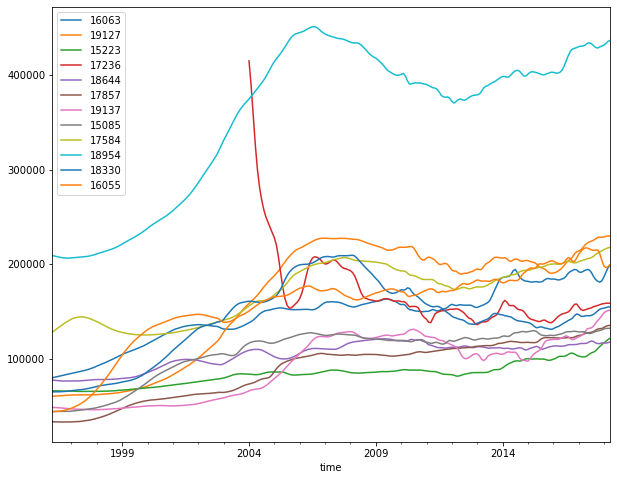

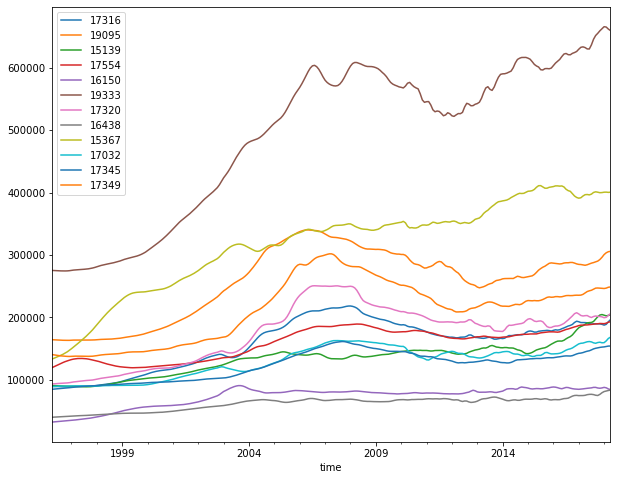

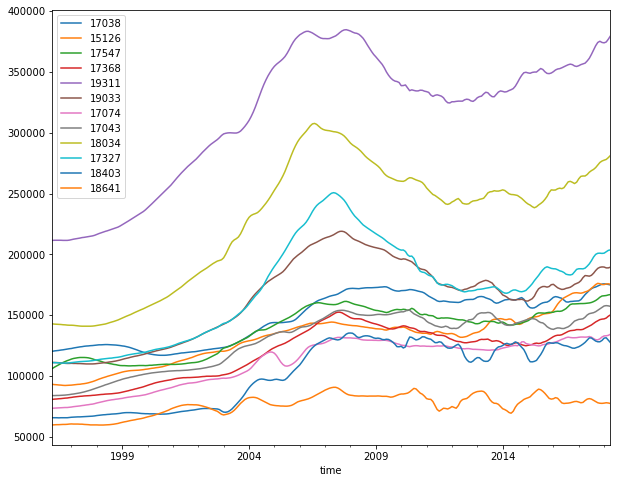

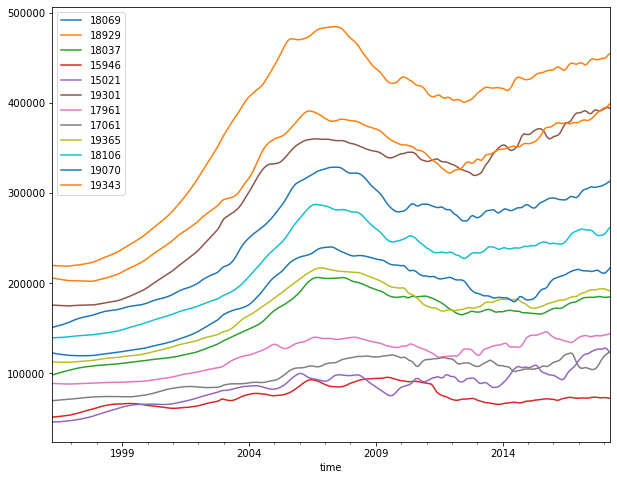

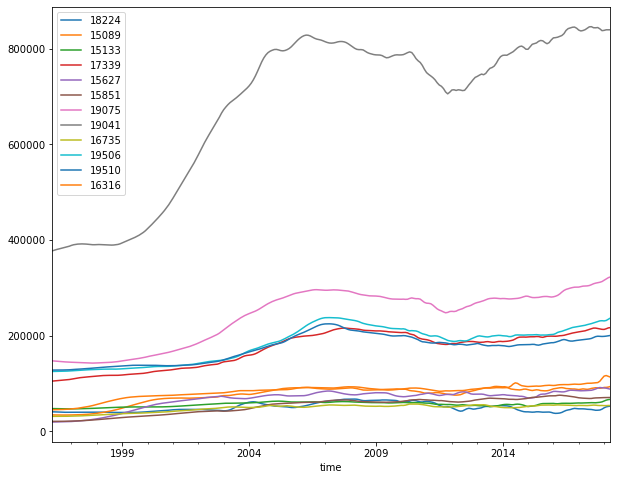

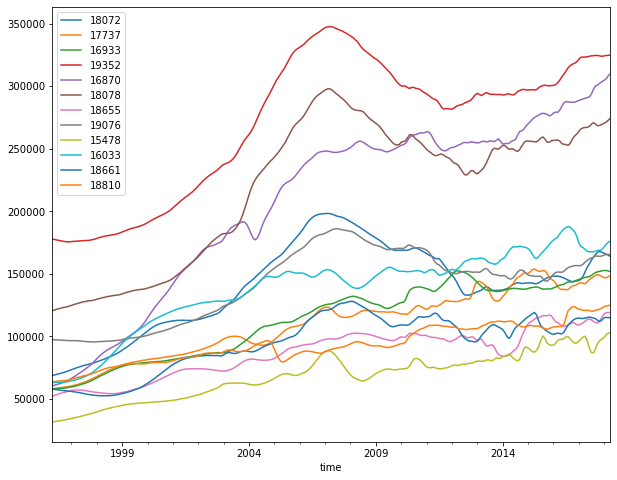

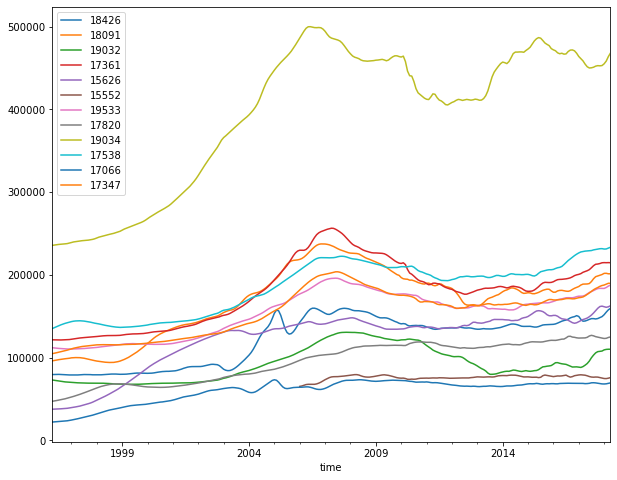

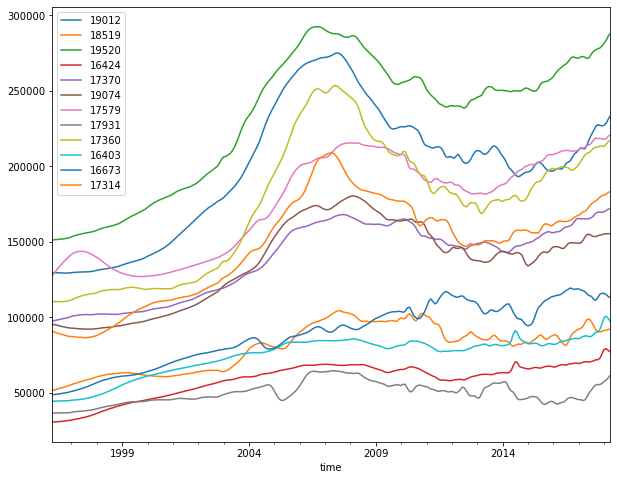

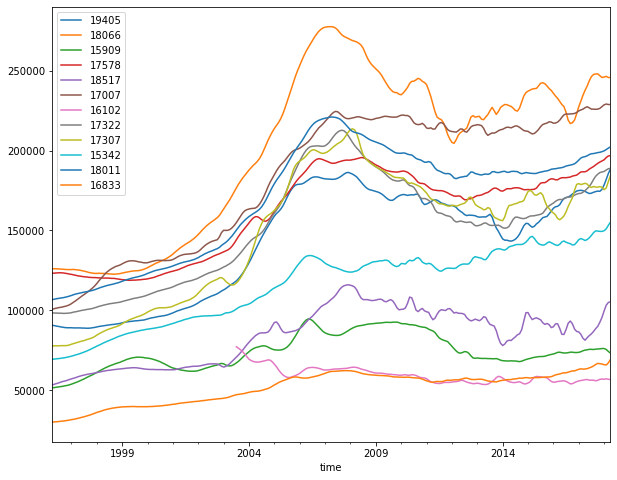

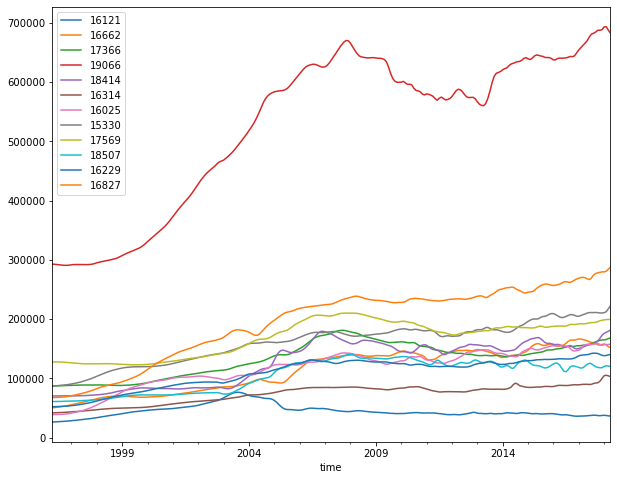

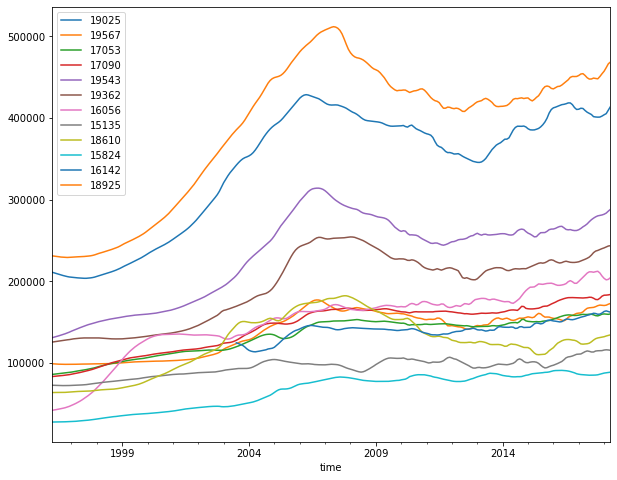

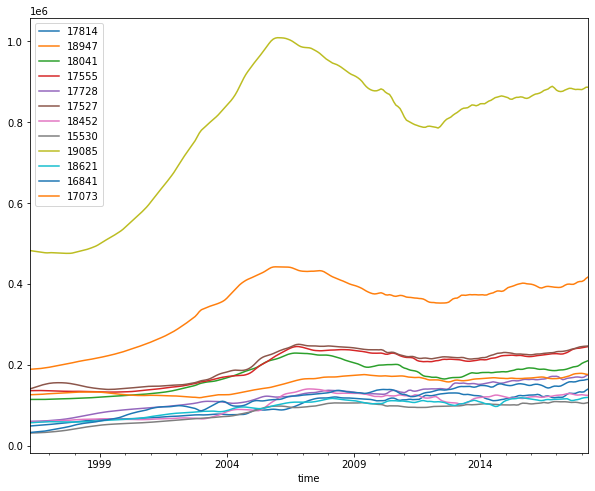

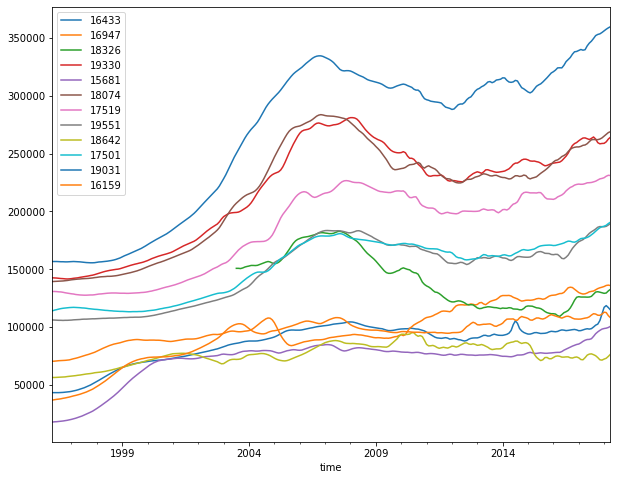

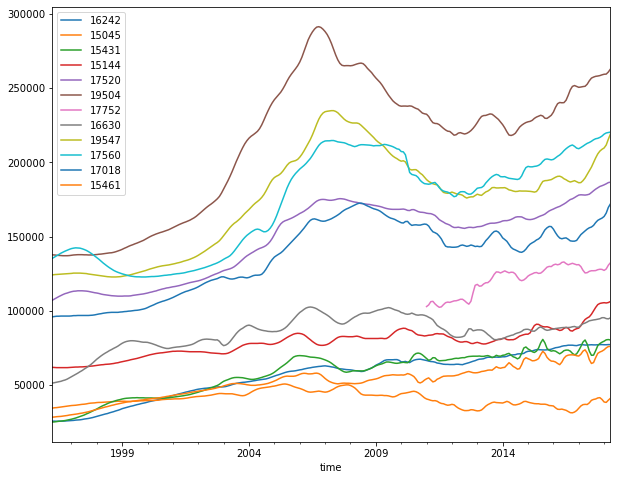

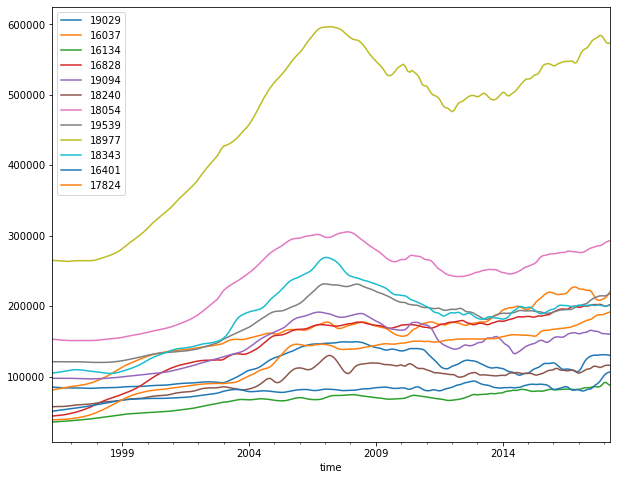

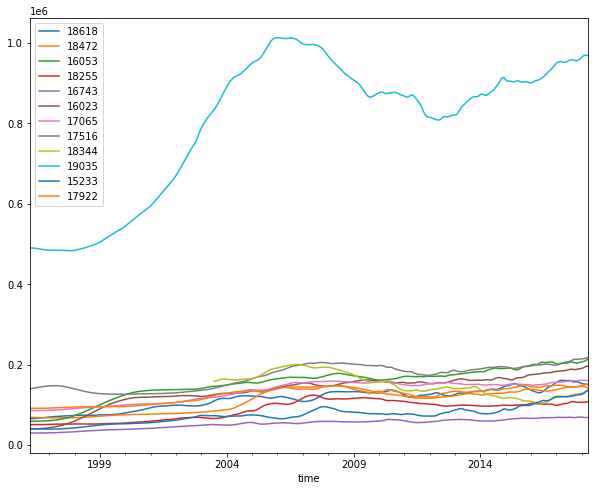

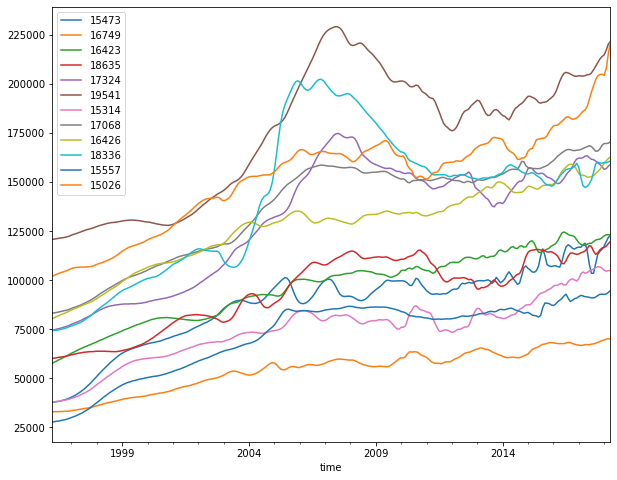

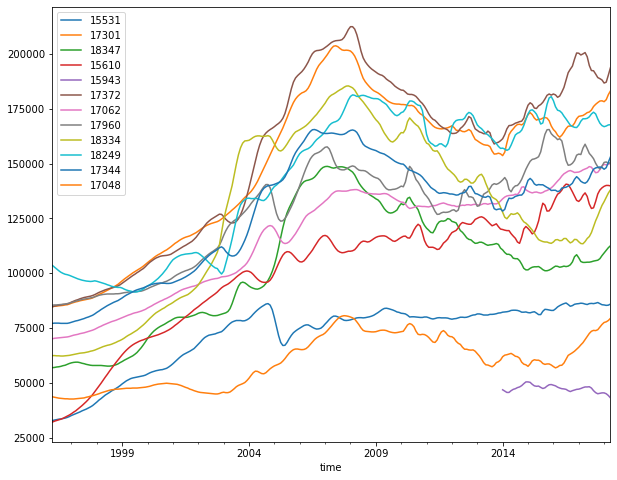

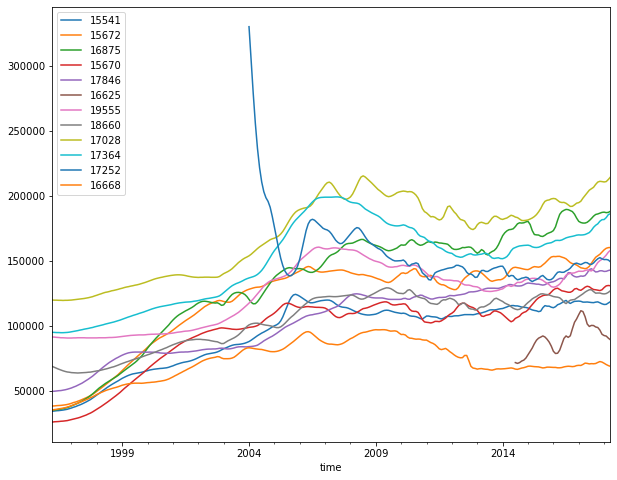

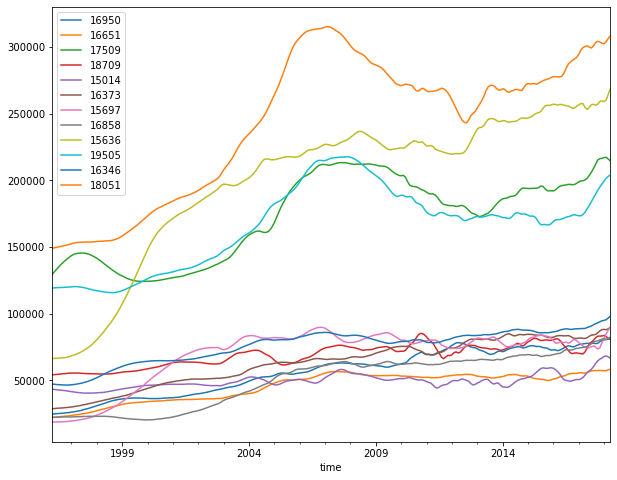

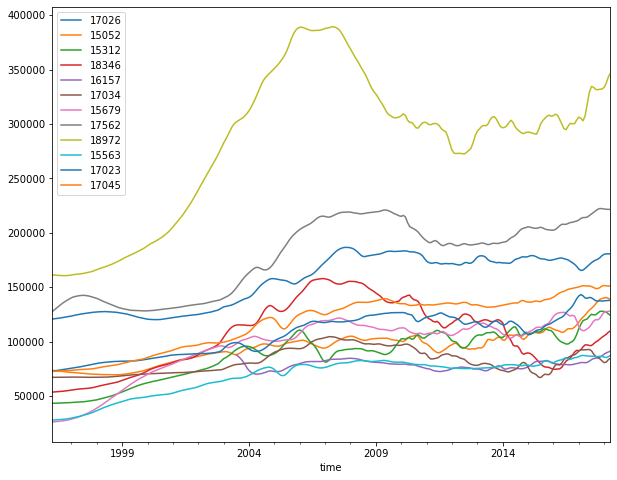

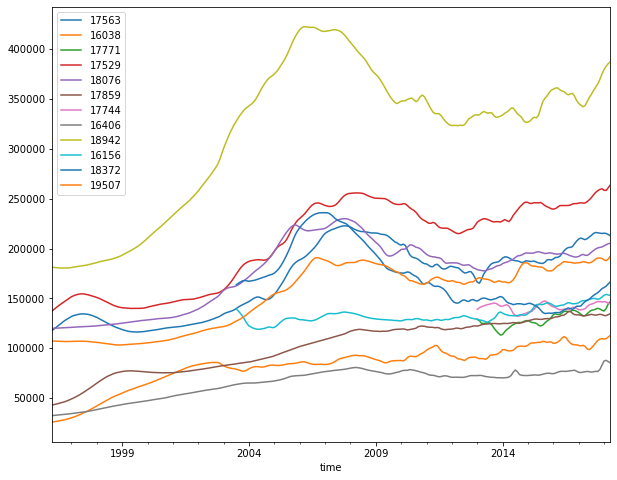

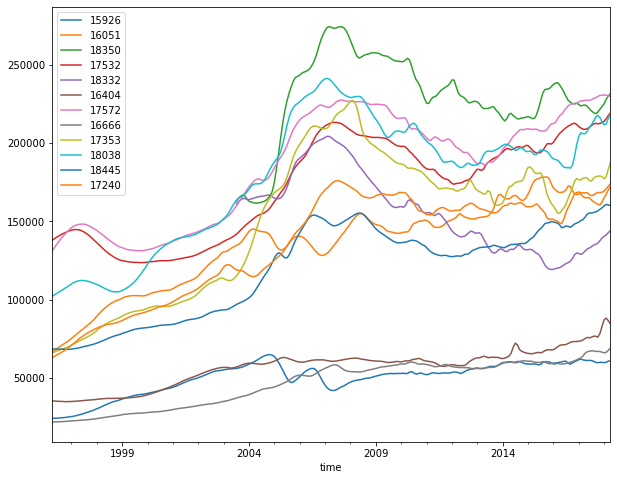

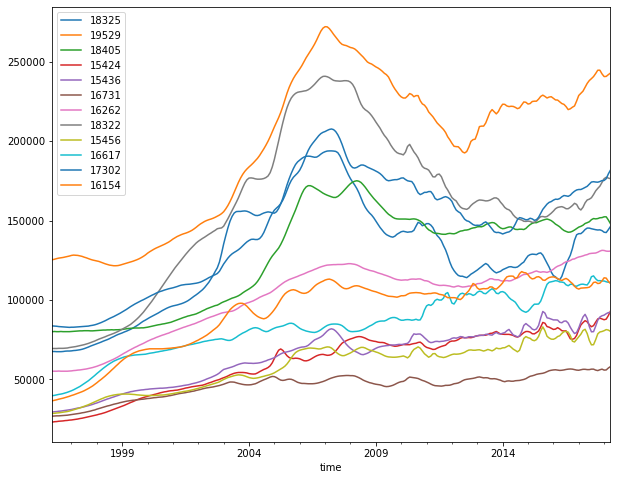

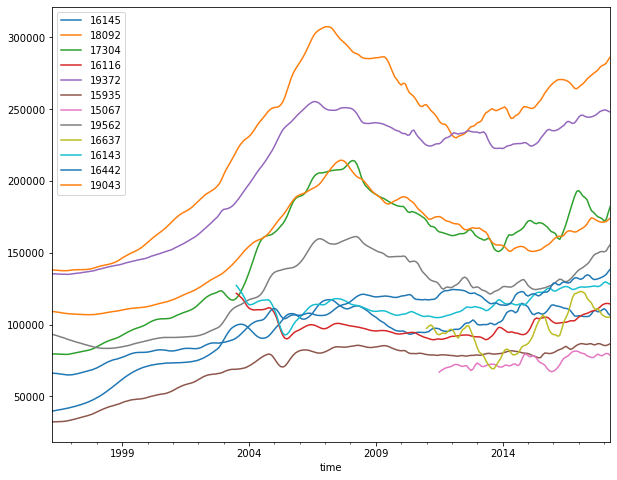

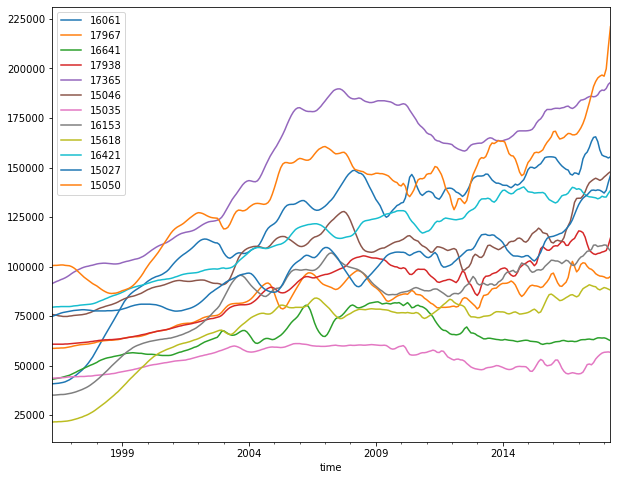

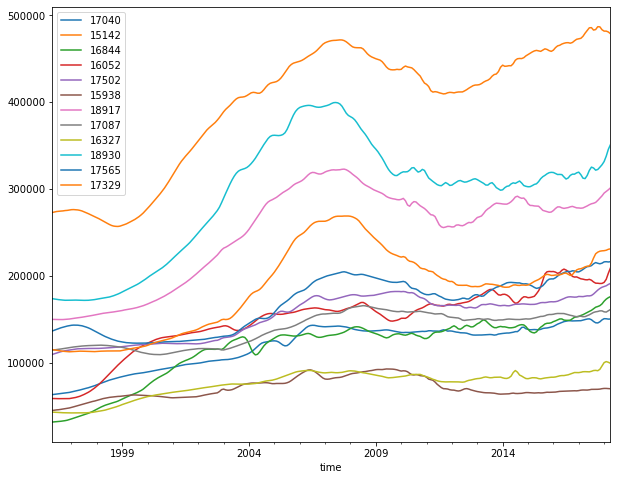

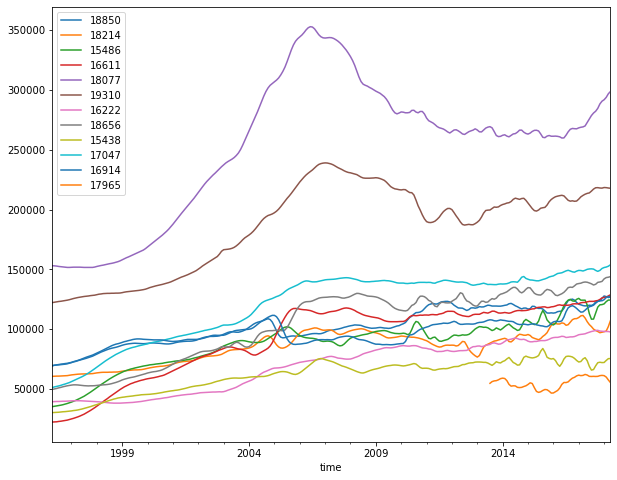

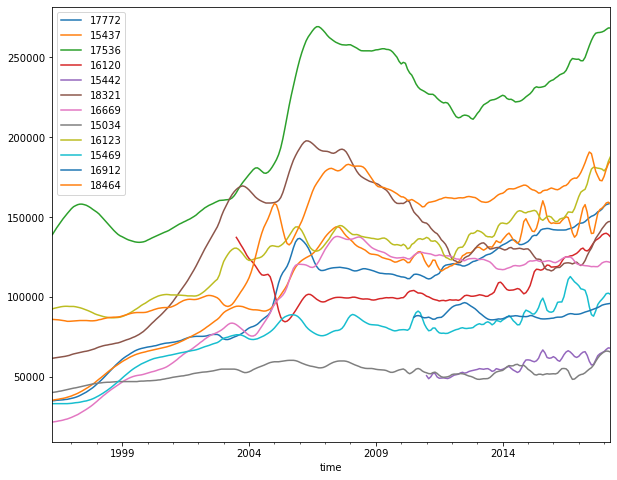

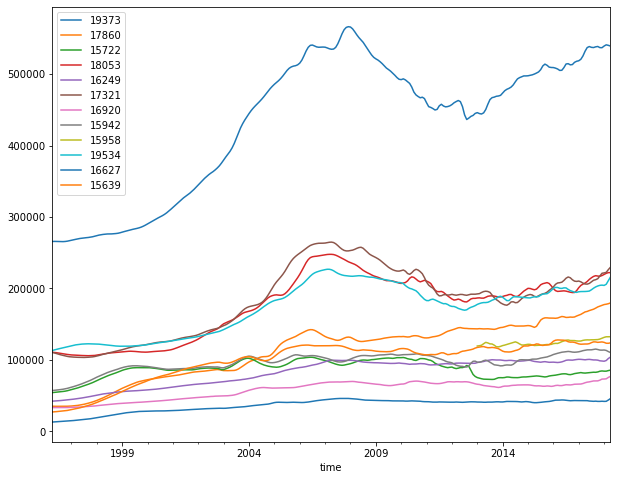

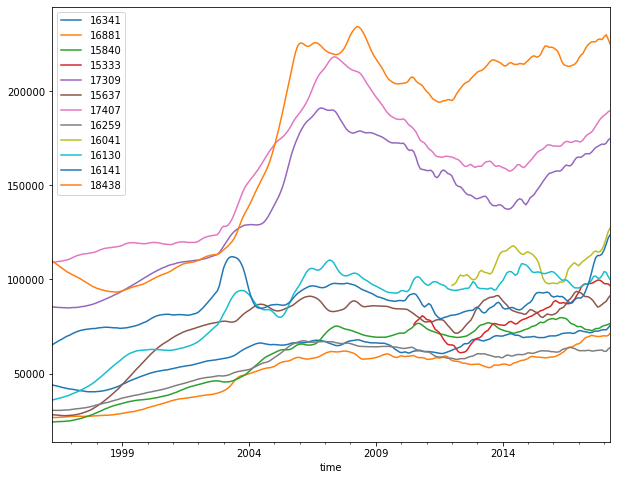

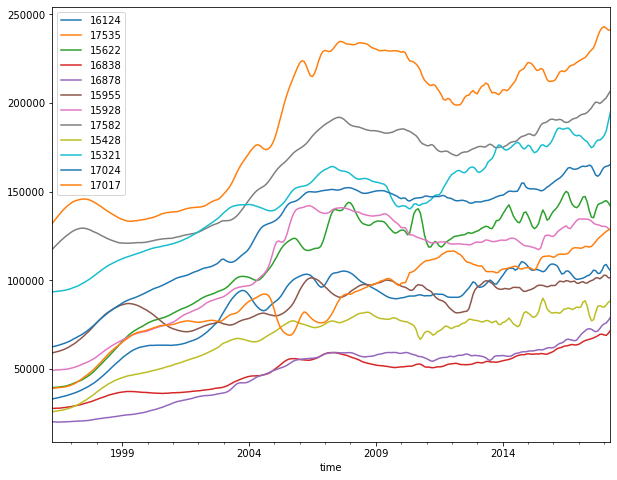

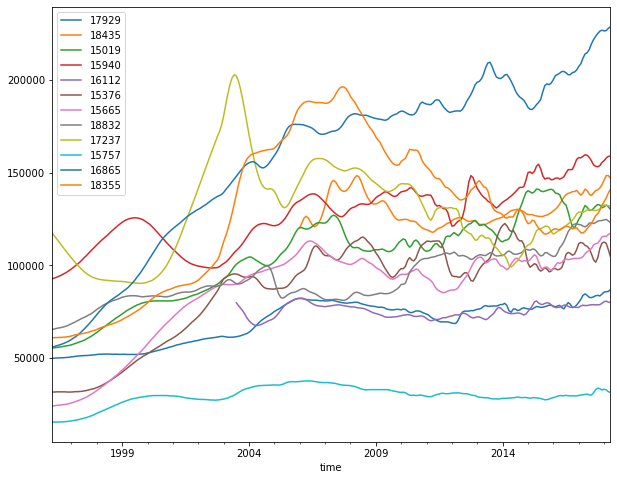

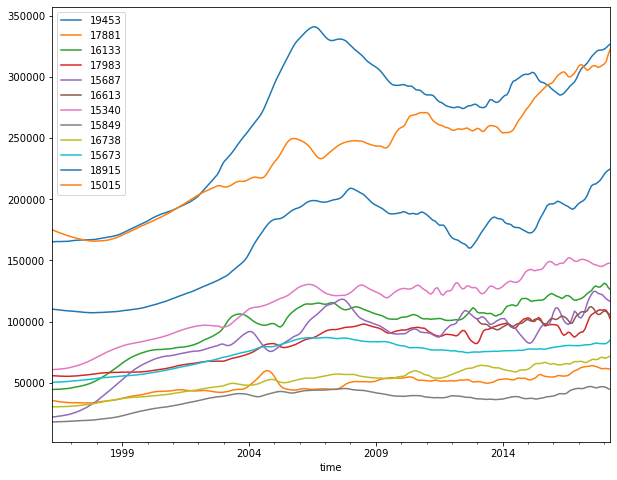

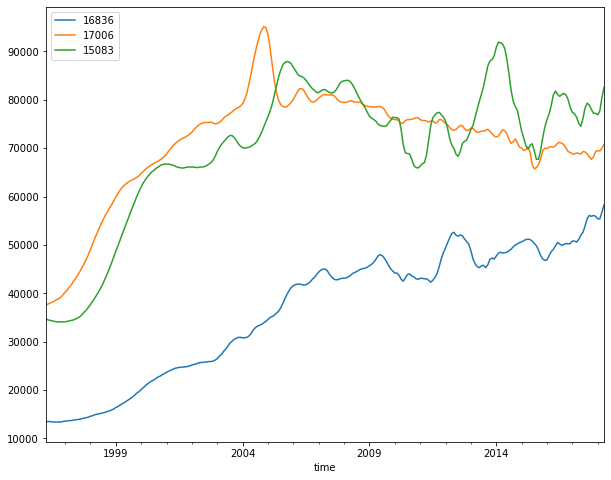

In [201]:
for x in range (0,len(df_pa_time.columns),12):
    #plt.figure(figsize=(6, 6))
    df_pa_time[df_pa_time.columns[x:x+12]].plot(legend=True, figsize=(10,8))
    plt.legend(loc='upper left')
    plt.show()

Ok, so after looking at these, I've decided the 5 zip codes I want to look at. I'll admit right away, this probably isn't the best way to go about this. But when it comes to real estate "buy low, sell high" doesn't apply as well as it does to other assets. And as you look at the graphs, most of these zip codes aren't really going anywhere.

In [202]:
zips=[19103,19106,19035,19085,19041]

In [203]:
zips_cols=[]
for x in range(831):
    if df_pa_time.columns[x] in zips:
        zips_cols.append(x)

In [204]:
zips_cols

[28, 185, 475, 560, 609]

In [205]:
for each in zips_cols:
    print(df_pa_time.columns[each])

19103
19106
19041
19085
19035


In [206]:
df_pa_19103=df_pa_time.iloc[:, [28]]
df_pa_19106=df_pa_time.iloc[:, [185]]
df_pa_19041=df_pa_time.iloc[:, [475]]
df_pa_19085=df_pa_time.iloc[:, [560]]
df_pa_19035=df_pa_time.iloc[:, [609]]
df_pa_19103_d=df_pa_time_d.iloc[:, [28]]
df_pa_19106_d=df_pa_time_d.iloc[:, [185]]
df_pa_19041_d=df_pa_time_d.iloc[:, [475]]
df_pa_19085_d=df_pa_time_d.iloc[:, [560]]
df_pa_19035_d=df_pa_time_d.iloc[:, [609]]

In [207]:
zips=[df_pa_19106,df_pa_19103,df_pa_19041,df_pa_19085,df_pa_19035]

In [208]:
df_pa_zips = pd.concat([df_pa_19106, df_pa_19103,df_pa_19041,df_pa_19085,df_pa_19035], axis=1, join='inner')

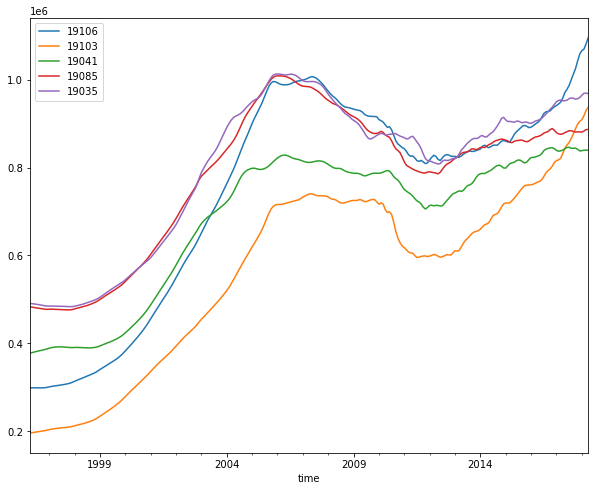

In [209]:
df_pa_zips.plot(legend=True, figsize=(10,8))
plt.legend(loc='upper left')
plt.show()

Ok, so we have our data. Let's get a simple baseline model. Here we'll just do a simple linear regression.

## Baseline Model: Linear Regression

So we need to do a train test split. The first thing I want to do is make a copy of a test dataframe, that I can use just for the linear regression, since there will be some changes/additions made to it. And instead of just removing them later....

In [210]:
df_pa_19035_lr=df_pa_time.iloc[:, [609]]
df_pa_19035=df_pa_time.iloc[:, [609]]

Now I'll need to make another column, since linear regression won't work with time series. Instead what I'll make is a simple counter to follow along with the time. I got this from class.

In [211]:
df_pa_19035_lr.insert(0, 't', range(len(df_pa_19035_lr)))

I'll use the last 2 years as the test set. Again, this is straight from class, creating a new column called 'future' that will be a 1 or 0 depending on if it's after 2016

In [212]:
df_pa_19035_lr['future'] = (df_pa_19035_lr.index.year > 2016).astype('int')

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [213]:
df_pa_19035_lr

t     19035  future
time                             
1996-04-01    0  490700.0       0
1996-05-01    1  490300.0       0
1996-06-01    2  489700.0       0
1996-07-01    3  489000.0       0
1996-08-01    4  488200.0       0
...         ...       ...     ...
2017-12-01  260  959600.0       1
2018-01-01  261  964600.0       1
2018-02-01  262  969200.0       1
2018-03-01  263  969600.0       1
2018-04-01  264  968200.0       1

[265 rows x 3 columns]

Another thing I've learned that I'll definitely avoid in the future, python/jupyter notebooks/ something here hates columns named using numbers (but it seemed like such a good idea at the time), so I need to change it so I can use it.

In [214]:
df_pa_19035_lr.columns=['t','target','future']

In [215]:
X_train = df_pa_19035_lr.loc[df_pa_19035_lr.future == 0, 't'].values.reshape(-1, 1)
X_test = df_pa_19035_lr.loc[df_pa_19035_lr.future == 1, 't'].values.reshape(-1, 1)
y_train = df_pa_19035_lr.loc[df_pa_19035_lr.future == 0, 'target'].values
y_test = df_pa_19035_lr.loc[df_pa_19035_lr.future == 1, 'target'].values

In [216]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [217]:
y_pred = lr.predict(X_test)
y_trend = lr.predict(X_train)

In [218]:
m=lr.coef_
b=lr.intercept_

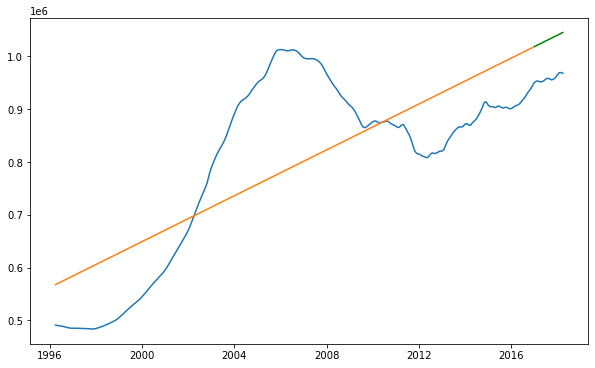

In [219]:
plt.figure(figsize=(10,6))
plt.plot(df_pa_19035_lr['target'])
plt.plot(df_pa_19035_lr.loc[df_pa_19035_lr.future == 0].index, y_trend)
plt.plot(df_pa_19035_lr.loc[df_pa_19035_lr.future == 1].index, y_pred, color='green')
plt.show()

So clearly this isn't a very good model, although it does seem to track in the same direction, but the predictions for this are going to be way off.

In [220]:
report_metrics(y_test,y_pred)

Explained Variance:
	 0.649840304208418
MAE:
	 73758.35007773033
RMSE:
	 73849.55402126773
r^2:
	 -140.85305045867037


In [221]:
df_future.insert(0, 't', range(len(df_future)))

In [222]:
df_future['t']=df_future['t']+265

In [223]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19035'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [224]:
df_future

t z19103 z19106 z19041 z19085     z19035
2018-05-01  265    NaN    NaN    NaN    NaN  [1047363]
2018-06-01  266    NaN    NaN    NaN    NaN  [1049174]
2018-07-01  267    NaN    NaN    NaN    NaN  [1050984]
2018-08-01  268    NaN    NaN    NaN    NaN  [1052794]
2018-09-01  269    NaN    NaN    NaN    NaN  [1054604]
2018-10-01  270    NaN    NaN    NaN    NaN  [1056414]
2018-11-01  271    NaN    NaN    NaN    NaN  [1058225]
2018-12-01  272    NaN    NaN    NaN    NaN  [1060035]
2019-01-01  273    NaN    NaN    NaN    NaN  [1061845]
2019-02-01  274    NaN    NaN    NaN    NaN  [1063655]
2019-03-01  275    NaN    NaN    NaN    NaN  [1065466]
2019-04-01  276    NaN    NaN    NaN    NaN  [1067276]
2019-05-01  277    NaN    NaN    NaN    NaN  [1069086]
2019-06-01  278    NaN    NaN    NaN    NaN  [1070896]
2019-07-01  279    NaN    NaN    NaN    NaN  [1072706]
2019-08-01  280    NaN    NaN    NaN    NaN  [1074517]
2019-09-01  281    NaN    NaN    NaN    NaN  [1076327]
2019-10-01  282    NaN    NaN    NaN    NaN  [1078137]
2019-11-01  283    NaN    NaN    NaN    NaN  [1079947]
2019-12-01  284    NaN    NaN    NaN    NaN  [1081757]
2020-01-01  285    NaN    NaN    NaN    NaN  [1083568]
2020-02-01  286    NaN    NaN    NaN    NaN  [1085378]
2020-03-01  287    NaN    NaN    NaN    NaN  [1087188]
2020-04-01  288    NaN    NaN    NaN    NaN  [1088998]
2020-05-01  289    NaN    NaN    NaN    NaN  [1090808]
2020-06-01  290    NaN    NaN    NaN    NaN  [1092619]
2020-07-01  291    NaN    NaN    NaN    NaN  [1094429]
2020-08-01  292    NaN    NaN    NaN    NaN  [1096239]
2020-09-01  293    NaN    NaN    NaN    NaN  [1098049]
2020-10-01  294    NaN    NaN    NaN    NaN  [1099860]
2020-11-01  295    NaN    NaN    NaN    NaN  [1101670]
2020-12-01  296    NaN    NaN    NaN    NaN  [1103480]
2021-01-01  297    NaN    NaN    NaN    NaN  [1105290]
2021-02-01  298    NaN    NaN    NaN    NaN  [1107100]
2021-03-01  299    NaN    NaN    NaN    NaN  [1108911]
2021-04-01  300    NaN    NaN    NaN    NaN  [1110721]
2021-05-01  301    NaN    NaN    NaN    NaN  [1112531]
2021-06-01  302    NaN    NaN    NaN    NaN  [1114341]
2021-07-01  303    NaN    NaN    NaN    NaN  [1116151]
2021-08-01  304    NaN    NaN    NaN    NaN  [1117962]
2021-09-01  305    NaN    NaN    NaN    NaN  [1119772]
2021-10-01  306    NaN    NaN    NaN    NaN  [1121582]
2021-11-01  307    NaN    NaN    NaN    NaN  [1123392]
2021-12-01  308    NaN    NaN    NaN    NaN  [1125202]
2022-01-01  309    NaN    NaN    NaN    NaN  [1127013]
2022-02-01  310    NaN    NaN    NaN    NaN  [1128823]
2022-03-01  311    NaN    NaN    NaN    NaN  [1130633]
2022-04-01  312    NaN    NaN    NaN    NaN  [1132443]
2022-05-01  313    NaN    NaN    NaN    NaN  [1134254]
2022-06-01  314    NaN    NaN    NaN    NaN  [1136064]
2022-07-01  315    NaN    NaN    NaN    NaN  [1137874]
2022-08-01  316    NaN    NaN    NaN    NaN  [1139684]
2022-09-01  317    NaN    NaN    NaN    NaN  [1141494]
2022-10-01  318    NaN    NaN    NaN    NaN  [1143305]
2022-11-01  319    NaN    NaN    NaN    NaN  [1145115]
2022-12-01  320    NaN    NaN    NaN    NaN  [1146925]
2023-01-01  321    NaN    NaN    NaN    NaN  [1148735]
2023-02-01  322    NaN    NaN    NaN    NaN  [1150545]
2023-03-01  323    NaN    NaN    NaN    NaN  [1152356]
2023-04-01  324    NaN    NaN    NaN    NaN  [1154166]

In [225]:
df_future['z19035'].astype(int)

2018-05-01    1047363
2018-06-01    1049174
2018-07-01    1050984
2018-08-01    1052794
2018-09-01    1054604
2018-10-01    1056414
2018-11-01    1058225
2018-12-01    1060035
2019-01-01    1061845
2019-02-01    1063655
2019-03-01    1065466
2019-04-01    1067276
2019-05-01    1069086
2019-06-01    1070896
2019-07-01    1072706
2019-08-01    1074517
2019-09-01    1076327
2019-10-01    1078137
2019-11-01    1079947
2019-12-01    1081757
2020-01-01    1083568
2020-02-01    1085378
2020-03-01    1087188
2020-04-01    1088998
2020-05-01    1090808
2020-06-01    1092619
2020-07-01    1094429
2020-08-01    1096239
2020-09-01    1098049
2020-10-01    1099860
2020-11-01    1101670
2020-12-01    1103480
2021-01-01    1105290
2021-02-01    1107100
2021-03-01    1108911
2021-04-01    1110721
2021-05-01    1112531
2021-06-01    1114341
2021-07-01    1116151
2021-08-01    1117962
2021-09-01    1119772
2021-10-01    1121582
2021-11-01    1123392
2021-12-01    1125202
2022-01-01    1127013
2022-02-01

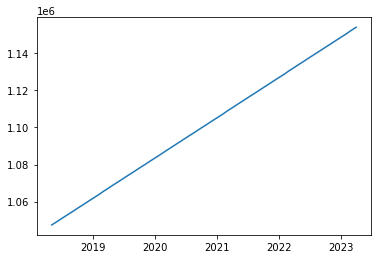

In [226]:
plt.plot(df_future['z19035'])

So it works. This is projecting the value of this property to go up to well over $1.14 million USD. So let's make this a function and loop the rest of the zip codes through it.

In [227]:
def lin_reg_mod(df):
    df.insert(0, 't', range(len(df)))
    df['future'] = (df.index.year > 2016).astype('int')
    df.columns=['t','target','future']
    X_train = df.loc[df.future == 0, 't'].values.reshape(-1, 1)
    X_test = df.loc[df.future == 1, 't'].values.reshape(-1, 1)
    y_train = df.loc[df.future == 0, 'target'].values
    y_test = df.loc[df.future == 1, 'target'].values
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    y_trend = lr.predict(X_train)
    plt.figure(figsize=(10,6))
    plt.plot(df['target'])
    plt.plot(df.loc[df.future == 0].index, y_trend)
    plt.plot(df.loc[df.future == 1].index, y_pred, color='green')
    plt.show()
    report_metrics(y_test,y_pred)
    m=lr.coef_
    b=lr.intercept_    
    
    return (m,b)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



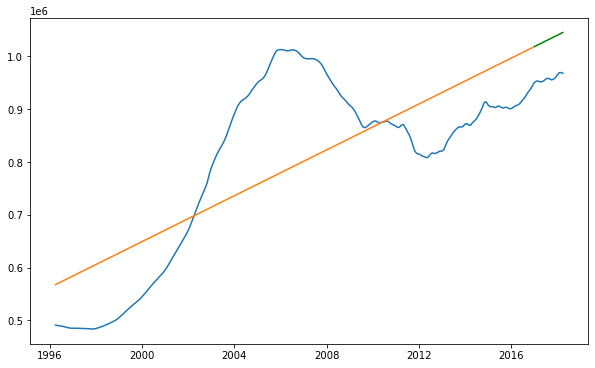

Explained Variance:
	 0.649840304208418
MAE:
	 73758.35007773033
RMSE:
	 73849.55402126773
r^2:
	 -140.85305045867037


In [228]:
m,b=lin_reg_mod(df_pa_19035)

In [229]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19035'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



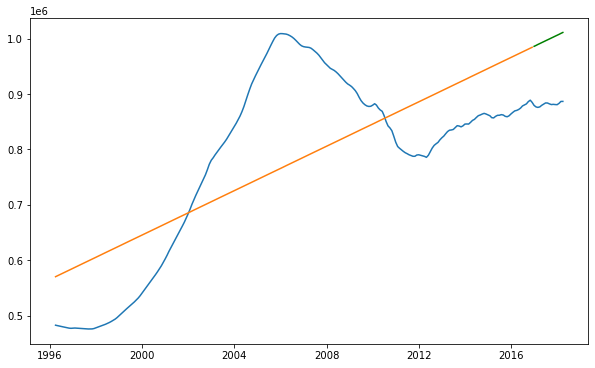

Explained Variance:
	 -2.3392189514936375
MAE:
	 117224.58585956736
RMSE:
	 117360.55215246363
r^2:
	 -1440.9740133367566


In [230]:
m,b=lin_reg_mod(df_pa_19085)

In [231]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19085'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



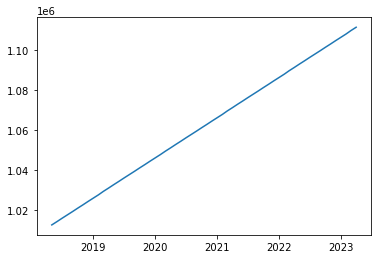

In [232]:
plt.plot(df_future['z19085'])

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



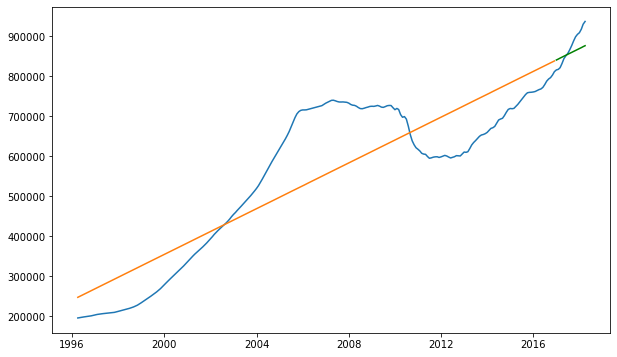

Explained Variance:
	 0.4780089774411922
MAE:
	 26660.47159606166
RMSE:
	 31949.54432906975
r^2:
	 0.34376450937553726


In [233]:
m,b=lin_reg_mod(df_pa_19103)

In [234]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19103'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



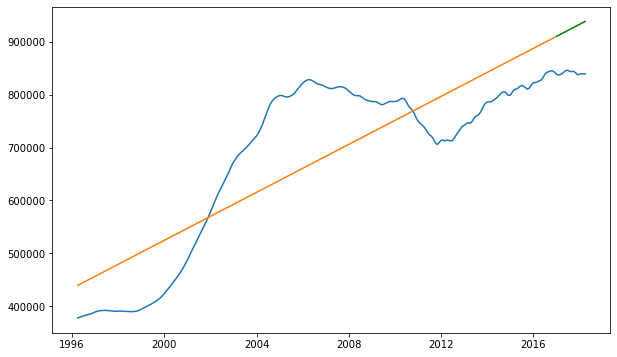

Explained Variance:
	 -9.537620904315752
MAE:
	 83312.79035496825
RMSE:
	 83829.54666135684
r^2:
	 -856.3626302704762


In [235]:
m,b=lin_reg_mod(df_pa_19041)

In [236]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19041'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



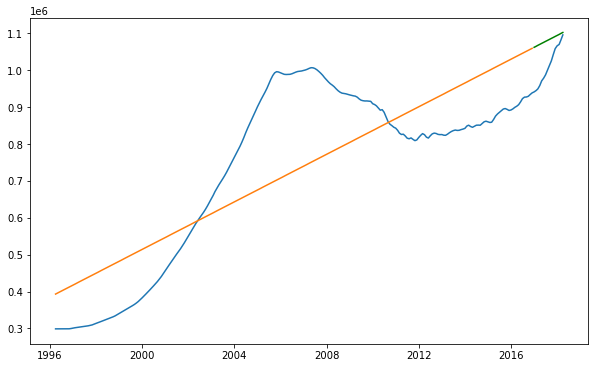

Explained Variance:
	 0.42547986073765187
MAE:
	 70660.98876149763
RMSE:
	 80466.07114359384
r^2:
	 -1.5103678851811955


In [237]:
m,b=lin_reg_mod(df_pa_19106)

In [238]:
for each in range(0,len(df_future['t'])):
    a=df_future['t'][each]
    dum2=(m*a)+b
    df_future['z19106'][each]=dum2.astype(int)

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



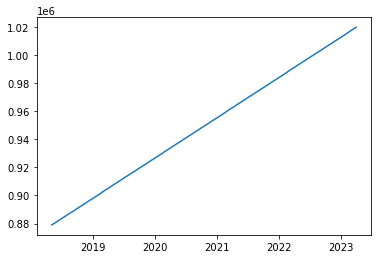

In [239]:
plt.plot(df_future['z19103'])

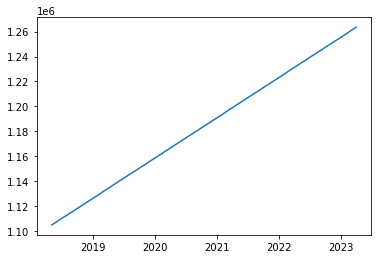

In [240]:
plt.plot(df_future['z19106'])

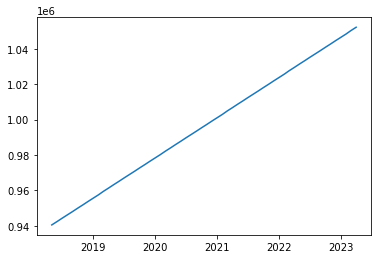

In [241]:
plt.plot(df_future['z19041'])

In [242]:
df_pa_19103=df_pa_time.iloc[:, [28]]
df_pa_19106=df_pa_time.iloc[:, [185]]
df_pa_19041=df_pa_time.iloc[:, [475]]
df_pa_19085=df_pa_time.iloc[:, [560]]
df_pa_19035=df_pa_time.iloc[:, [609]]

# Auto ARIMA
So now we're ready to do some REAL modeling. So our data run from 1996-2018. That's 20 years of data, so I'm thinking use most of this for training, and the last 2 for testing. But before we do that, we'll need to check for nulls, then split, then model.

In [243]:
print (df_pa_19035.isna().sum())
print (df_pa_19085.isna().sum())
print (df_pa_19103.isna().sum())
print (df_pa_19041.isna().sum())
print (df_pa_19106.isna().sum())

19035    0
dtype: int64
19085    0
dtype: int64
19103    0
dtype: int64
19041    0
dtype: int64
19106    0
dtype: int64


In [244]:
train_data, test_data = temporal_train_test_split(df_pa_19035, test_size=24)
print(train_data.shape[0], test_data.shape[0])

241 24


In [245]:
test_19035=test_data.squeeze()
train_19035=train_data.squeeze()

In [246]:
arima = pm.auto_arima(train_19035,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,stepwise=False,
                      seasonal=True, m=1)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4258.540, Time=0.00 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4272.211, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4280.122, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4298.288, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4293.941, Time=0.10 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4296.975, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4261.094, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4282.540, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4283.870, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4300.245, Time=0.07 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4299.632, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4282.627, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4306.155, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4306.494, Time=0.05 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4304.463, Time=0.05 sec
 ARIMA(3,2

In [247]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  241
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2128.270
Date:                Sun, 30 May 2021   AIC                           4258.540
Time:                        17:13:07   BIC                           4262.016
Sample:                             0   HQIC                          4259.941
                                - 241                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.152e+06   1.67e+05     18.894      0.000    2.83e+06    3.48e+06
===================================================================================
Ljung-Box (L1) (Q):                  20.10   Jarque-Bera (JB):               160.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.12   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [248]:
y_pred = arima.predict(n_periods=test_data.shape[0])

In [249]:
report_metrics(test_data,y_pred)

Explained Variance:
	 0.6923575442211545
MAE:
	 23658.333333333332
RMSE:
	 25607.51842721196
r^2:
	 -1.1007877680483733


Well, slightly better than the linear regression

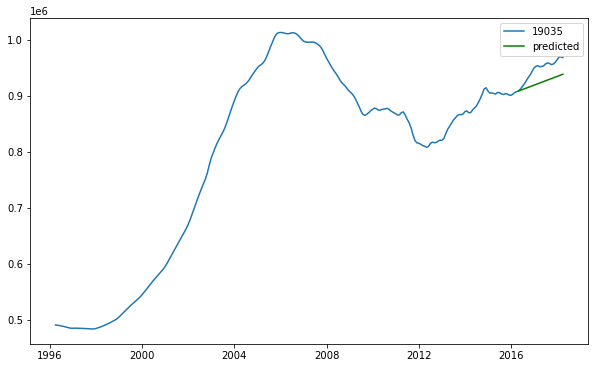

In [250]:
plt.figure(figsize=(10,6))
plt.plot(df_pa_19035, label = df_pa_19035.columns[0])
plt.plot(test_19035.index, y_pred, color='green', label = 'predicted')
plt.legend()
plt.show()

In [251]:
y_pred_2=arima.predict(n_periods=(test_data.shape[0] + 60))

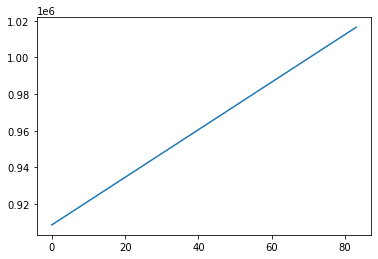

In [252]:
plt.plot(y_pred_2)

Here's our function to automate this.

In [253]:
def arima_mod(df,tst_size=24,ms_out=60):
    """This function will take in a dataframe with a single time-series variable, along with the size of the test sample,
    how far into the future you want to predict (in months out). It will then split the dataframe and run an Auto ARIMA model, print the summary
    as well as validation metrics of the model."""
    train_data,test_data= temporal_train_test_split(df, test_size=tst_size)
    test=test_data.squeeze()
    train=train_data.squeeze()
    arima = pm.auto_arima(train, max_p=15, max_q=15, max_P=6,max_D=4,max_Q=6,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,stepwise=False,
                      seasonal=True, m=1)
    arima.summary()
    future=test_data.shape[0] + ms_out
    y_pred = arima.predict(n_periods=test_data.shape[0])
    y_pred_2=arima.predict(n_periods=future)
    report_metrics(test_data,y_pred)
    plt.figure(figsize=(10,6))
    plt.plot(df, label = df.columns[0])
    plt.plot(test.index, y_pred, color='green', label = 'predicted')
    plt.legend()
    plt.show()
    plt.plot(y_pred_2)
    return None

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4119.585, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4125.478, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4132.664, Time=0.05 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4145.224, Time=0.06 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4152.636, Time=0.12 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4147.401, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4121.986, Time=0.00 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4128.805, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4136.221, Time=0.05 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4148.179, Time=0.05 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4154.649, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4145.743, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4152.833, Time=0.05 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4152.958, Time=0.06 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4154.112, Time=0.07 sec
 ARIMA(3,2

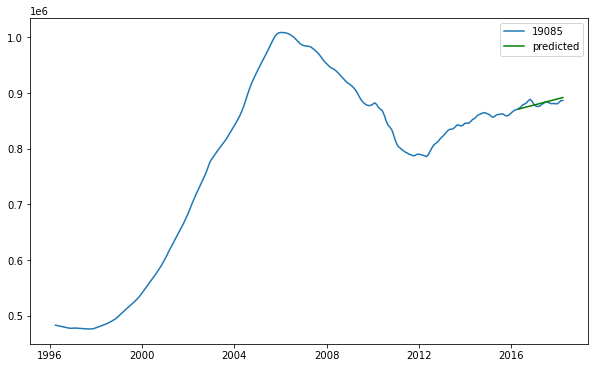

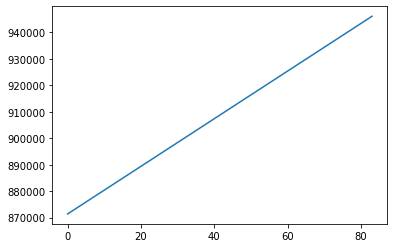

In [254]:
arima_mod(df_pa_19085)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4175.918, Time=0.00 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4185.468, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4190.356, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4220.844, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4211.622, Time=0.05 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4203.064, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4179.053, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4188.087, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4195.538, Time=0.14 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=inf, Time=0.29 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4214.017, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4218.919, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.29 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4221.727, Time=0.16 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4227.864, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)

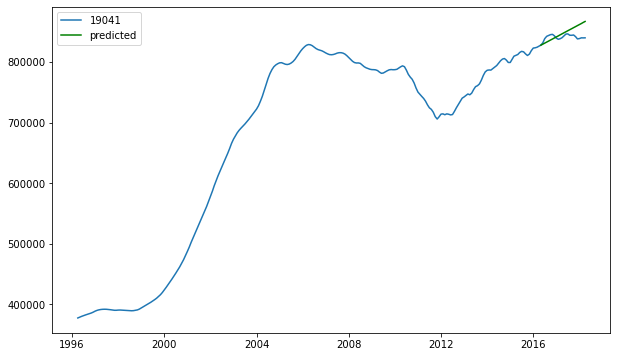

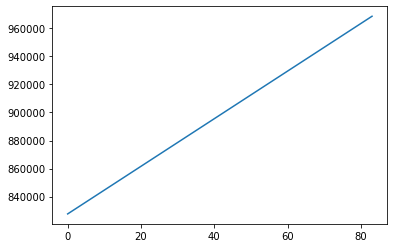

In [255]:
arima_mod(df_pa_19041)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4335.212, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4337.056, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4341.710, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4359.332, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4354.776, Time=0.10 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4349.496, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4337.120, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4339.055, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4337.646, Time=0.31 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4339.450, Time=0.74 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4358.200, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4349.655, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4348.228, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4348.928, Time=0.27 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4366.660, Time=0.49 sec
 ARIMA(3,2

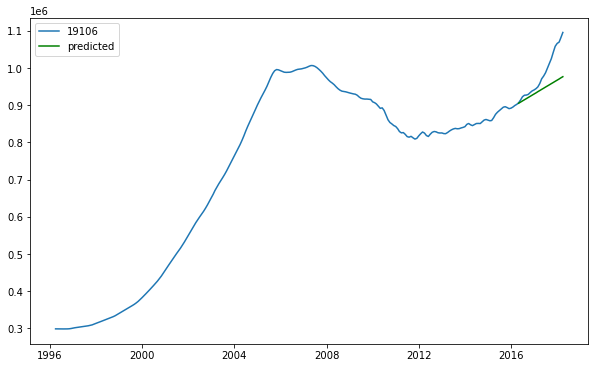

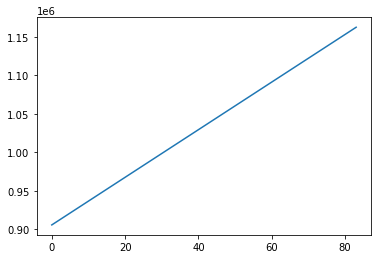

In [256]:
arima_mod(df_pa_19106)

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4356.306, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4358.608, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4369.902, Time=0.03 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4355.564, Time=0.18 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4384.677, Time=0.05 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=inf, Time=0.58 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4357.899, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4360.191, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4354.233, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=4355.868, Time=0.38 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4392.310, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4400.690, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=4354.288, Time=0.34 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4404.202, Time=0.14 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4407.189, Time=0.29 sec
 ARIMA(3,2,0)(0

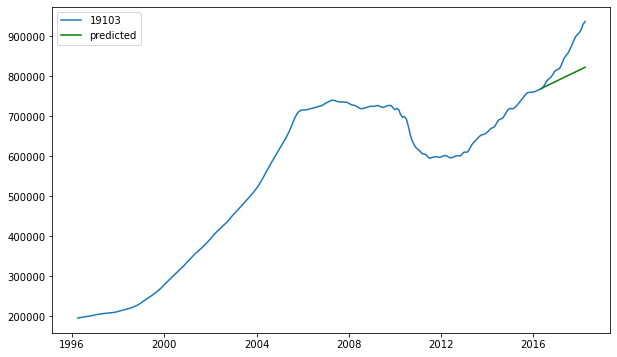

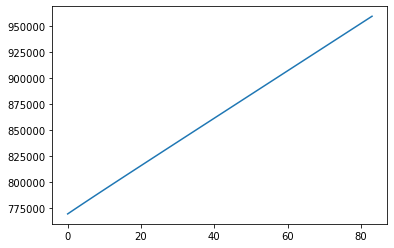

In [257]:
arima_mod(df_pa_19103)

In [258]:
df_pa_19106=df_pa_time.iloc[:, [185]]
df_pa_19041=df_pa_time.iloc[:, [475]]
df_pa_19085=df_pa_time.iloc[:, [560]]
df_pa_19035=df_pa_time.iloc[:, [609]]
df_pa_19103=df_pa_time.iloc[:, [28]]

# Prophet

Let's step away from Auto ARIMA for a second, and try our new toy: prophet. From Facebook. Now I'm going to deviate from their instructions and try to do things the standard way. There will be some changes that need to be made to the dataframe to get it in useful condition. One of the things I'm going to do is set the frequency for my trainging and testing data to weekly.

In [259]:
prof_1 = Prophet()

In [260]:
df_pa_19106_d.index.names = ['ds']
df_pa_19106_d.columns=['y']

In [261]:
df_pa_19106_d.reset_index(level=0, inplace=True)

In [262]:
prof_1.fit(df_pa_19106_d)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [263]:
future = prof_1.make_future_dataframe(periods=730)

In [264]:
future

ds
0    1996-04-01
1    1996-04-02
2    1996-04-03
3    1996-04-04
4    1996-04-05
...         ...
8761 2020-03-27
8762 2020-03-28
8763 2020-03-29
8764 2020-03-30
8765 2020-03-31

[8766 rows x 1 columns]

In [265]:
forecast = prof_1.predict(future)

In [266]:
forecast.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 1996-04-01  299388.469905  283621.140524  312162.286971  299388.469905   
1 1996-04-02  299389.602724  283563.989640  312680.533982  299389.602724   
2 1996-04-03  299390.735542  285727.543342  312431.190273  299390.735542   
3 1996-04-04  299391.868361  284415.383226  311133.779508  299391.868361   
4 1996-04-05  299393.001179  284038.515730  312081.557755  299393.001179   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  299388.469905     -902.446152           -902.446152           -902.446152   
1  299389.602724    -1085.363829          -1085.363829          -1085.363829   
2  299390.735542    -1231.968671          -1231.968671          -1231.968671   
3  299391.868361    -1389.604057          -1389.604057          -1389.604057   
4  299393.001179    -1539.536295          -1539.536295          -1539.536295   

      weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0 -17.567251    -17.567251    -17.567251  -884.878901   -884.878901   
1 -31.032946    -31.032946    -31.032946 -1054.330883  -1054.330883   
2  -9.739577     -9.739577     -9.739577 -1222.229093  -1222.229093   
3  -2.858080     -2.858080     -2.858080 -1386.745977  -1386.745977   
4   6.563698      6.563698      6.563698 -1546.099993  -1546.099993   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   -884.878901                   0.0                         0.0   
1  -1054.330883                   0.0                         0.0   
2  -1222.229093                   0.0                         0.0   
3  -1386.745977                   0.0                         0.0   
4  -1546.099993                   0.0                         0.0   

   multiplicative_terms_upper           yhat  
0                         0.0  298486.023754  
1                         0.0  298304.238895  
2                         0.0  298158.766872  
3                         0.0  298002.264304  
4                         0.0  297853.464885

The column 'yhat' is the one with the actual predicted value.

In [267]:
proph_pred=forecast['yhat']

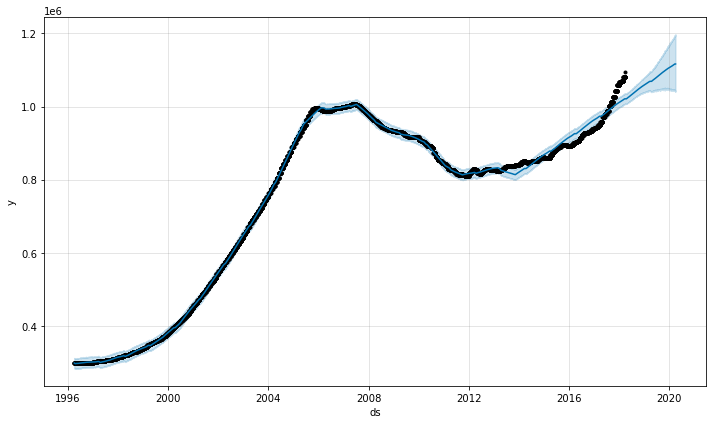

In [268]:
prof_1.plot(forecast)
plt.show()

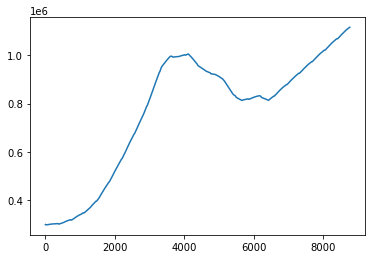

In [269]:
proph_pred.plot()

In [270]:
preds=proph_pred.tail(48)

This takes a long time, maybe don't run this cell when it comes time for evaluation

In [271]:
df_19106_cv = cross_validation(prof_1, initial='1048 days', period='30 days', horizon = '730 days')

INFO:prophet:Making 209 forecasts with cutoffs between 1999-03-02 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

In [272]:
df_19106_cv

ds           yhat     yhat_lower    yhat_upper          y  \
0      1999-03-03  344704.303295  344138.087428  3.453366e+05   346400.0   
1      1999-03-04  344761.404814  344149.717953  3.453726e+05   346400.0   
2      1999-03-05  344827.813805  344195.726761  3.454388e+05   346400.0   
3      1999-03-06  344887.396641  344300.466510  3.454810e+05   346400.0   
4      1999-03-07  344967.396992  344353.999068  3.455768e+05   346400.0   
...           ...            ...            ...           ...        ...   
152565 2018-03-28  931232.993056  849893.495358  1.008946e+06  1081700.0   
152566 2018-03-29  931270.492047  849012.611637  1.007962e+06  1081700.0   
152567 2018-03-30  931300.160417  848393.531530  1.007835e+06  1081700.0   
152568 2018-03-31  931342.572350  848699.213918  1.010349e+06  1081700.0   
152569 2018-04-01  931373.985091  847818.240227  1.008696e+06  1095700.0   

           cutoff  
0      1999-03-02  
1      1999-03-02  
2      1999-03-02  
3      1999-03-02  
4      1999-03-02  
...           ...  
152565 2016-04-01  
152566 2016-04-01  
152567 2016-04-01  
152568 2016-04-01  
152569 2016-04-01  

[152570 rows x 6 columns]

In [273]:
df_19106_pm = performance_metrics(df_19106_cv)

In [274]:
df_19106_pm

horizon           mse           rmse           mae      mape     mdape  \
0    73 days  4.570222e+08   21378.078127  15650.868601  0.018054  0.012635   
1    74 days  4.612480e+08   21476.684751  15725.723663  0.018145  0.012719   
2    75 days  4.654691e+08   21574.733849  15799.924610  0.018236  0.012782   
3    76 days  4.697328e+08   21673.320617  15874.979001  0.018329  0.012872   
4    77 days  4.740080e+08   21771.725212  15950.061958  0.018421  0.012987   
..       ...           ...            ...           ...       ...       ...   
653 726 days  1.198837e+10  109491.429116  87705.991186  0.101354  0.084115   
654 727 days  1.202736e+10  109669.338212  87859.985929  0.101519  0.084227   
655 728 days  1.206667e+10  109848.414729  88013.825709  0.101683  0.084283   
656 729 days  1.210687e+10  110031.244382  88168.881025  0.101847  0.084505   
657 730 days  1.214753e+10  110215.854292  88323.723632  0.102011  0.084659   

        smape  coverage  
0    0.018067  0.185489  
1    0.018158  0.185095  
2    0.018249  0.184833  
3    0.018340  0.184505  
4    0.018432  0.184243  
..        ...       ...  
653  0.100809  0.290555  
654  0.100970  0.289965  
655  0.101131  0.289506  
656  0.101292  0.289179  
657  0.101452  0.288982  

[658 rows x 8 columns]

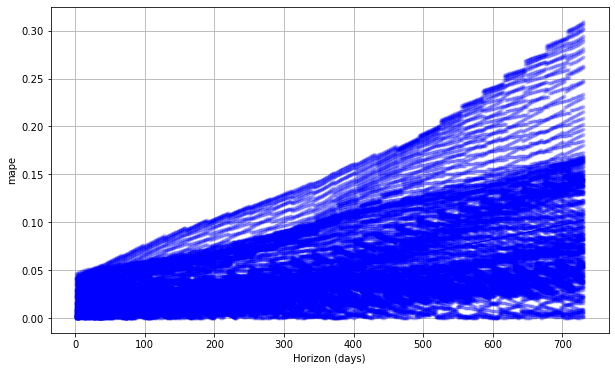

In [275]:
fig = plot_cross_validation_metric(df_19106_cv, metric='mape')

In [276]:
g=9
h=str(g)+ ' days'
print (type(h))

<class 'str'>


In [277]:
def proph(df, train_sz=6941,fr_cast=1825):
    """This function will run Prophet models on a given dataframe. The df must be in days, as well as the train size and forecast."""
    model=Prophet()
    df.index.names = ['ds']
    df.columns=['y']
    df.reset_index(level=0, inplace=True)
    model.fit(df)
    conv_train= str(train_sz)+' days'
    conv_fcast= str(fr_cast) + ' days'    
    future = model.make_future_dataframe(periods=fr_cast)
    forecast = model.predict(future)
    proph_pred=forecast['yhat']
    prof_1.plot(forecast)
    plt.show()
    df_cv = cross_validation(model, initial='7036 days', period='30 days', horizon ='730 days')
    df_pm = performance_metrics(df_cv)
    print(df_pm.tail())
    fig = plot_cross_validation_metric(df_cv, metric='mape')

In [278]:
df_pa_19085_d=df_pa_time_d.iloc[:, [560]]
df_pa_19041_d=df_pa_time_d.iloc[:, [475]]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


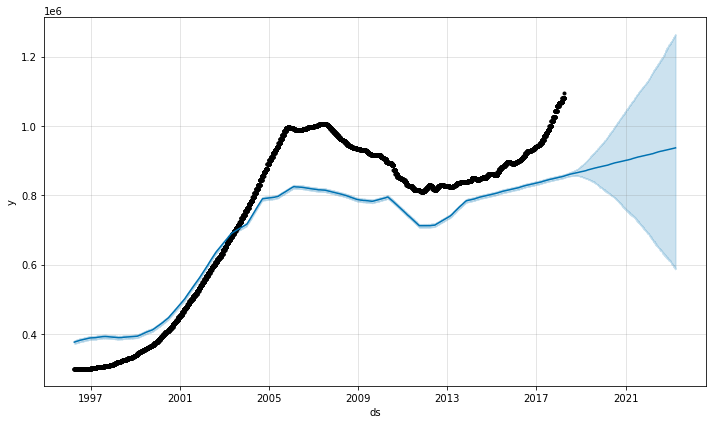

INFO:prophet:Making 9 forecasts with cutoffs between 2015-08-05 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

     horizon           mse          rmse           mae      mape     mdape  \
653 726 days  2.473108e+09  49730.357173  49320.113862  0.058581  0.057397   
654 727 days  2.483425e+09  49833.977198  49424.878707  0.058707  0.057614   
655 728 days  2.493739e+09  49937.347322  49529.400044  0.058832  0.057813   
656 729 days  2.505228e+09  50052.253303  49644.627320  0.058971  0.058093   
657 730 days  2.516662e+09  50166.341658  49759.240415  0.059109  0.058356   

        smape  coverage  
653  0.056887       1.0  
654  0.057005       1.0  
655  0.057124       1.0  
656  0.057255       1.0  
657  0.057385       1.0  


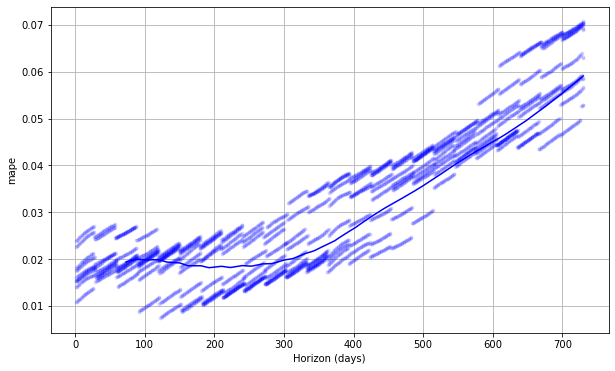

In [279]:
proph(df_pa_19041_d)

In [280]:
df_pa_19106_d=df_pa_time_d.iloc[:, [185]]
df_pa_19041_d=df_pa_time_d.iloc[:, [475]]
df_pa_19085_d=df_pa_time_d.iloc[:, [560]]
df_pa_19035_d=df_pa_time_d.iloc[:, [609]]
df_pa_19103_d=df_pa_time_d.iloc[:, [28]]

In [281]:
zips_d=[df_pa_19106_d,df_pa_19085_d,df_pa_19103_d,df_pa_19035_d]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


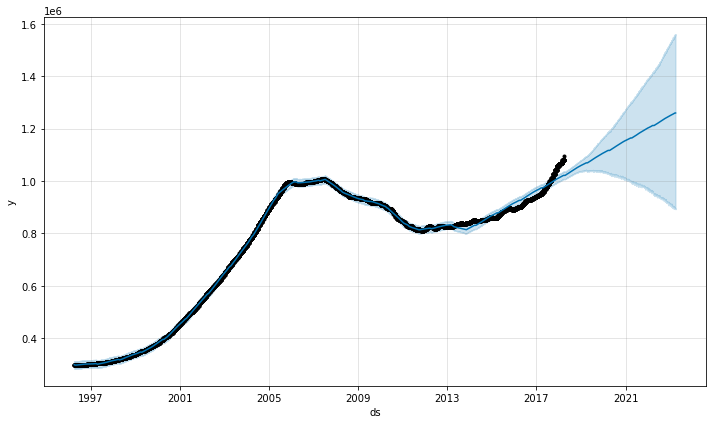

INFO:prophet:Making 9 forecasts with cutoffs between 2015-08-05 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     horizon           mse           rmse            mae      mape     mdape  \
653 726 days  1.343514e+10  115910.060083  113445.626442  0.109597  0.107051   
654 727 days  1.349408e+10  116164.009916  113717.925809  0.109830  0.107108   
655 728 days  1.356091e+10  116451.326064  114028.301144  0.110097  0.107234   
656 729 days  1.364579e+10  116815.200803  114407.897705  0.110421  0.107435   
657 730 days  1.374072e+10  117220.811030  114820.911156  0.110772  0.107680   

        smape  coverage  
653  0.116180       0.0  
654  0.116439       0.0  
655  0.116736       0.0  
656  0.117099       0.0  
657  0.117492       0.0  


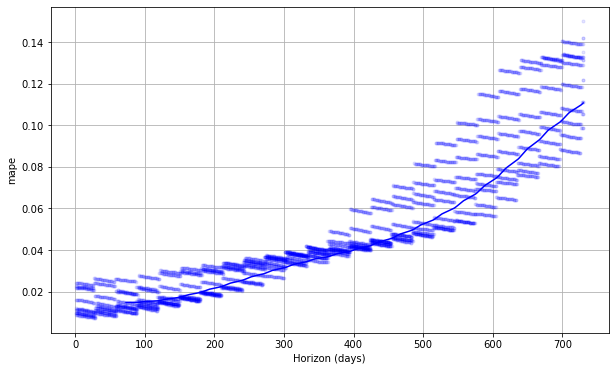

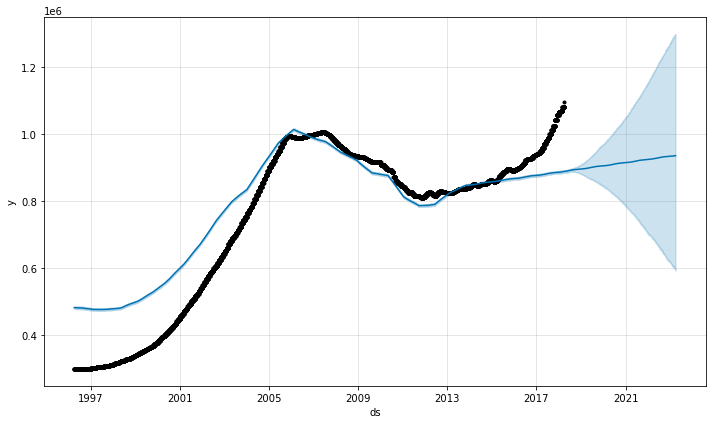

INFO:prophet:Making 9 forecasts with cutoffs between 2015-08-05 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     horizon           mse          rmse           mae      mape     mdape  \
653 726 days  1.380937e+09  37160.967155  37088.924653  0.042041  0.042308   
654 727 days  1.384586e+09  37210.020955  37136.625755  0.042094  0.042361   
655 728 days  1.388646e+09  37264.541958  37189.232340  0.042154  0.042448   
656 729 days  1.392433e+09  37315.314273  37237.682159  0.042208  0.042529   
657 730 days  1.396294e+09  37367.017356  37286.962471  0.042263  0.042577   

        smape  coverage  
653  0.041172       1.0  
654  0.041223       1.0  
655  0.041280       1.0  
656  0.041332       1.0  
657  0.041385       1.0  


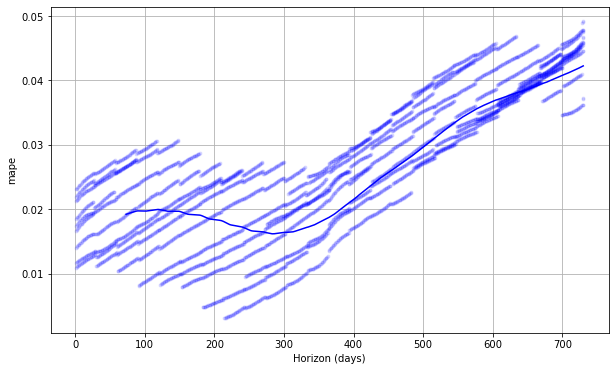

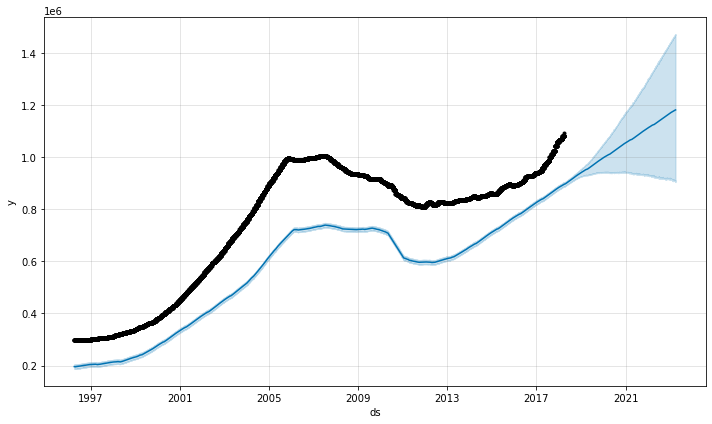

INFO:prophet:Making 9 forecasts with cutoffs between 2015-08-05 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     horizon           mse          rmse           mae      mape     mdape  \
653 726 days  2.726302e+09  52214.003032  51808.394907  0.058238  0.058500   
654 727 days  2.738740e+09  52332.969624  51932.170796  0.058363  0.058609   
655 728 days  2.754797e+09  52486.157074  52089.551769  0.058523  0.058771   
656 729 days  2.776186e+09  52689.528105  52290.949420  0.058729  0.058932   
657 730 days  2.799737e+09  52912.539888  52509.552532  0.058952  0.059184   

        smape  coverage  
653  0.060005  0.980213  
654  0.060136  0.980213  
655  0.060307  0.980213  
656  0.060525  0.978691  
657  0.060762  0.977169  


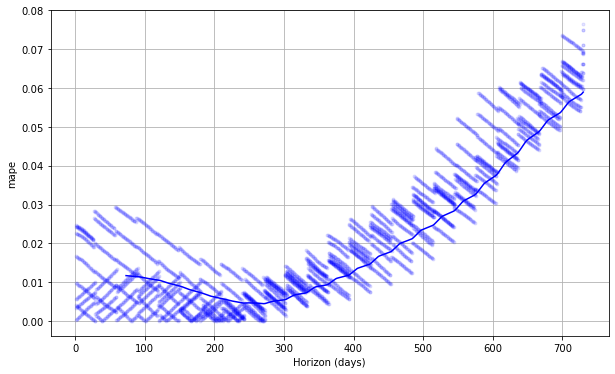

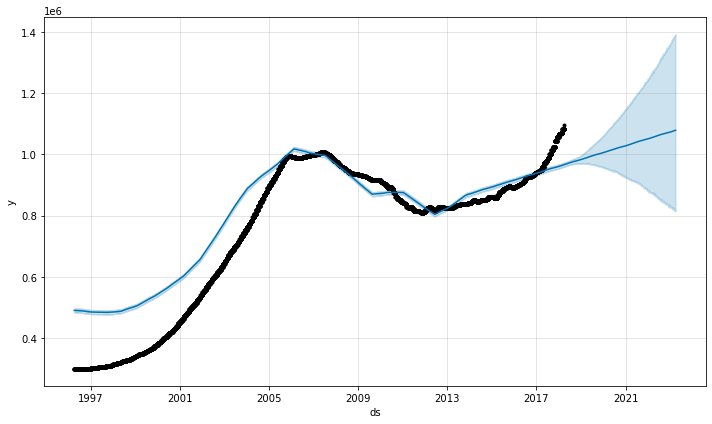

INFO:prophet:Making 9 forecasts with cutoffs between 2015-08-05 00:00:00 and 2016-04-01 00:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

     horizon           mse          rmse           mae      mape     mdape  \
653 726 days  3.347602e+08  18296.454137  17460.083134  0.018197  0.018025   
654 727 days  3.363453e+08  18339.720453  17500.928585  0.018239  0.018070   
655 728 days  3.381291e+08  18388.286987  17546.989251  0.018286  0.018133   
656 729 days  3.396340e+08  18429.162460  17587.356799  0.018328  0.018220   
657 730 days  3.408953e+08  18463.351270  17622.978296  0.018364  0.018257   

        smape  coverage  
653  0.018018       1.0  
654  0.018058       1.0  
655  0.018105       1.0  
656  0.018145       1.0  
657  0.018180       1.0  


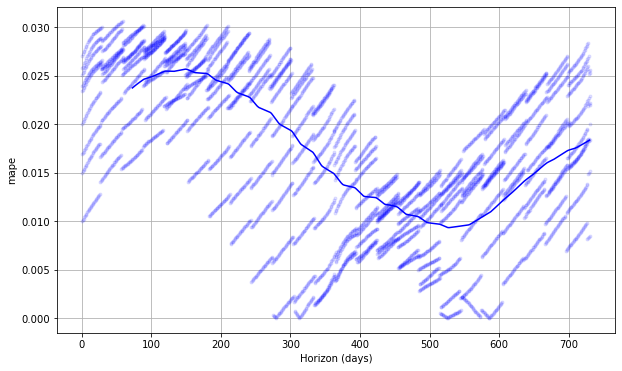

In [282]:
for each in zips_d:
    proph(each)

# Revisiting ARIMA

Here, just as a single experiment, I wanted to see if the daily data will yield a better result than the monthly stuff.

In [283]:
train_data_19041_d, test_data_19041_d = temporal_train_test_split(df_pa_19041_d, test_size=1440)

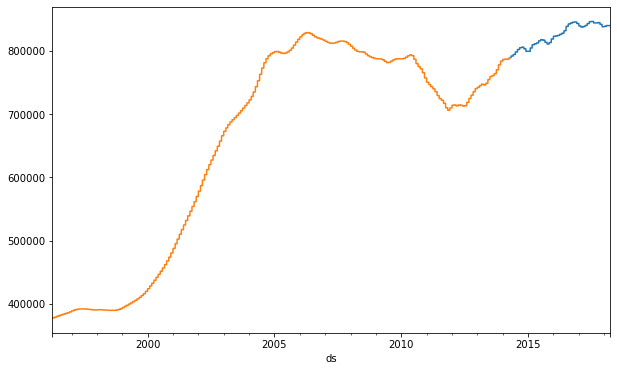

In [284]:
test_19041_d=test_data_19041_d.squeeze()
train_19041_d=train_data_19041_d.squeeze()
plt.figure(figsize=(10,6))
test_19041_d.plot()
train_19041_d.plot()
plt.show()

 ARIMA(0,2,0)(0,0,0)[1]             : AIC=4175.918, Time=0.00 sec
 ARIMA(0,2,1)(0,0,0)[1]             : AIC=4185.468, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[1]             : AIC=4190.356, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[1]             : AIC=4220.844, Time=0.05 sec
 ARIMA(0,2,4)(0,0,0)[1]             : AIC=4211.622, Time=0.05 sec
 ARIMA(0,2,5)(0,0,0)[1]             : AIC=4203.064, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[1]             : AIC=4179.053, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[1]             : AIC=4188.087, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[1]             : AIC=4195.538, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[1]             : AIC=inf, Time=0.22 sec
 ARIMA(1,2,4)(0,0,0)[1]             : AIC=4214.017, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[1]             : AIC=4218.919, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[1]             : AIC=inf, Time=0.26 sec
 ARIMA(2,2,2)(0,0,0)[1]             : AIC=4221.727, Time=0.17 sec
 ARIMA(2,2,3)(0,0,0)[1]             : AIC=4227.864, Time=0.26 sec
 ARIMA(3,2,0)(0,0,0)

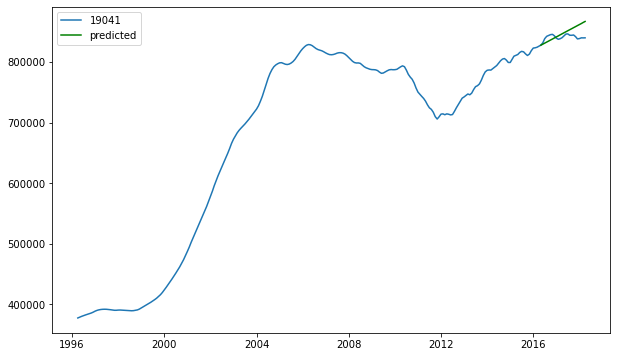

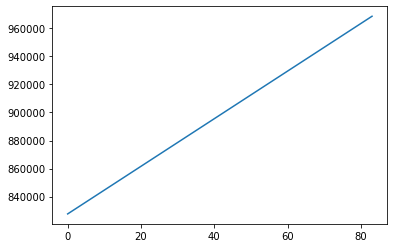

In [285]:
arima_4 = arima_mod(df_pa_19041)

In [286]:
arima_4d = pm.auto_arima(train_19041_d, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=200,
                      seasonal=True, m=15)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[15]             : AIC=inf, Time=18.90 sec
 ARIMA(0,2,0)(0,0,0)[15]             : AIC=110820.906, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[15]             : AIC=110558.246, Time=0.50 sec
 ARIMA(0,2,1)(0,0,1)[15]             : AIC=110393.282, Time=1.55 sec
 ARIMA(0,2,1)(0,0,0)[15]             : AIC=110391.282, Time=0.60 sec
 ARIMA(0,2,1)(1,0,0)[15]             : AIC=110393.282, Time=1.54 sec
 ARIMA(0,2,1)(1,0,1)[15]             : AIC=inf, Time=2.52 sec
 ARIMA(1,2,1)(0,0,0)[15]             : AIC=110232.870, Time=1.11 sec
 ARIMA(1,2,1)(1,0,0)[15]             : AIC=110234.870, Time=3.03 sec
 ARIMA(1,2,1)(0,0,1)[15]             : AIC=110234.870, Time=3.21 sec
 ARIMA(1,2,1)(1,0,1)[15]             : AIC=inf, Time=5.74 sec
 ARIMA(1,2,0)(0,0,0)[15]             : AIC=110445.545, Time=0.57 sec
 ARIMA(2,2,1)(0,0,0)[15]             : AIC=110234.803, Time=2.36 sec
 ARIMA(1,2,2)(0,0,0)[15]             : AIC=110234.803, Time=2.86 sec
 ARIMA(0,2,

In [287]:
y_pred_4d = arima_4d.predict(n_periods=test_data_19041_d.shape[0])
arima_4d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 6596
Model:               SARIMAX(1, 2, 1)   Log Likelihood              -55113.435
Date:                Sun, 30 May 2021   AIC                         110232.870
Time:                        18:39:52   BIC                         110253.252
Sample:                             0   HQIC                        110239.914
                               - 6596                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5182      0.003    158.944      0.000       0.512       0.525
ma.L1         -0.6935      0.004   -187.062      0.000      -0.701      -0.686
sigma2      1.016e+06   3997.552    254.215      0.000    1.01e+06    1.02e+06
===================================================================================
Ljung-Box (L1) (Q):                 914.62   Jarque-Bera (JB):            592412.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [288]:
report_metrics(test_data_19041_d,y_pred_4d)

Explained Variance:
	 0.008245742023365255
MAE:
	 35580.21357343376
RMSE:
	 39555.17700188696
r^2:
	 -4.195559167740212


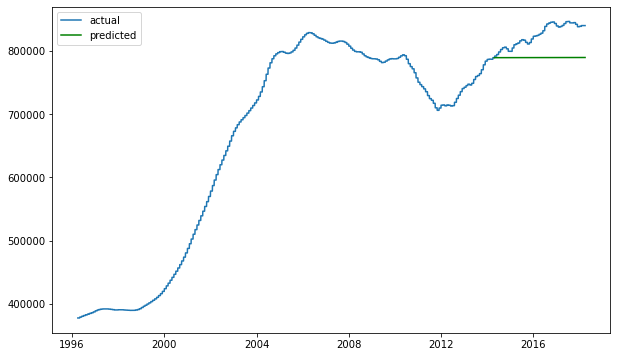

In [289]:
plt.figure(figsize=(10,6))
plt.plot(df_pa_19041_d, label = 'actual')
plt.plot(test_19041_d.index, y_pred_4d, color='green', label = 'predicted')
plt.legend()
plt.show()

So it seems like auto ARIMA is doing even worse with the daily data. At least in this test case.

# Conclusion:
Obviously, as usual, more work needs to be done to refine and improve these models. Again, obviously, ARIMA did better than Linear Regression, while the results from Prophet were not as simple to interpret, I do believe they gave the best results.